# 回归

In [4]:
from pathlib import Path
import sys
import os
root_dir = str(Path(os.getcwd()).parent)
sys.path.append(root_dir)

import pandas as pd
import datetime
import numpy as np
import statsmodels.api as sm
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from report.evaluate.regression import get_interval_rets, reg
from report.util import get_trade_date
from statsmodels.iolib.summary2 import summary_col

## 主回归

### 事前

In [ ]:
reg_data_before_file = f'{root_dir}/data/reg_data/reg_data_before.parquet'
if os.path.isfile(reg_data_before_file):
	reg_data_before = pq.read_table(reg_data_before_file).to_pandas()
else:
	factor_data_tech = pq.read_table(f'{root_dir}/data/intermediate_results/factor_data_tech.parquet').to_pandas()
	trade_date_lag = pq.read_table(f'{root_dir}/data/intermediate_results/trade_date_lag.parquet').to_pandas()
	factor_data_fundamentall =  pq.read_table(f'{root_dir}/data/intermediate_results/factor_data_fundamentall.parquet').to_pandas()
	yysj_pro = pq.read_table(f'{root_dir}/data/intermediate_results/yysj_pro.parquet').to_pandas()
	stk_info = pq.read_table(f'{root_dir}/data/intermediate_results/stk_info.parquet').to_pandas()

	index_data = pq.read_table(f'{root_dir}/data/intermediate_results/index_data.parquet').to_pandas()
	index_data = index_data.loc[index_data['stock_symbol']=='000001']
	index_data = pd.merge(left=trade_date_lag, right=index_data.drop(columns=['stock_symbol']), on=['trade_date'], how='left')

	factor_data_tech = pd.merge(left=trade_date_lag, right=factor_data_tech, on=['stock_symbol', 'trade_date'], how='left')

	reg_data_before = pd.merge(left=factor_data_tech, right=factor_data_fundamentall.drop(columns=['report_type']), left_on=['stock_symbol', 'report_type'], right_on=['stock_symbol', 'report_type_lag1'], how='left')
	reg_data_before['bm'] = reg_data_before['asset'] / reg_data_before['market_cap']
	reg_data_before['ue'] = reg_data_before['net_profit'] / (reg_data_before['market_cap'] / reg_data_before['close'])
	reg_data_before = pd.merge(left=reg_data_before, right=yysj_pro, on=['stock_symbol', 'report_type'], how='left')
	reg_data_before = pd.merge(left=reg_data_before, right=stk_info[['stock_symbol','listed_date']], on=['stock_symbol'], how='left')
	reg_data_before.to_parquet(reg_data_before_file)
reg_data_before

,stock_symbol,report_type,trade_date,lag,state,rets1,rets2,close,pre_close,volume,...,ia,report_type_lag1,bm,type,book_time_rank_first,book_time_rank_last,report_time_rank_last,days_to_startline,days_to_deadline,listed_date
0,000001,20061231,2007-02-01,-30,NaN,NaN,NaN,NaN,NaN,NaN,...,0.184639,20061231,NaN,1231,0.280000,0.280000,0.280784,80.0,39.0,1991-04-03
1,000002,20061231,2007-01-30,-30,1.0,-0.062673,-0.062673,16.90,18.03,91582843.0,...,0.746689,20061231,776.856683,1231,0.247843,0.247843,0.247843,78.0,41.0,1991-01-29
2,000004,20061231,2007-03-16,-30,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.380771,20061231,NaN,1231,0.873725,0.873725,0.874510,116.0,3.0,1991-01-14
3,000006,20061231,2007-02-05,-30,1.0,0.010714,0.010714,11.32,11.20,6013728.0,...,0.362139,20061231,1137.328676,1231,0.309804,0.309804,0.309804,82.0,37.0,1992-04-27
4,000007,20061231,2007-03-09,-30,1.0,0.057644,0.057644,4.22,3.99,12979270.0,...,-0.147582,20061231,961.198500,1231,0.734118,0.734118,0.737255,109.0,10.0,1992-04-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12782728,688799,20240930,2024-12-10,30,1.0,-0.007729,-0.007729,41.08,41.40,1265099.0,...,NaN,None,NaN,0930,0.355142,0.350833,0.350833,28.0,2.0,2021-07-13
12782729,688800,20240930,2024-12-06,30,1.0,-0.032621,-0.032621,42.11,43.53,5025279.0,...,NaN,None,NaN,0930,0.100686,0.100881,0.100881,24.0,6.0,2021-07-22
12782730,688819,20240930,2024-12-11,30,1.0,0.009672,0.009672,29.23,28.95,2574608.0,...,NaN,None,NaN,0930,0.529481,0.526543,0.526543,29.0,1.0,2021-01-18
12782731,688981,20240930,2024-12-20,30,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,None,NaN,0930,0.999412,0.999412,0.999412,38.0,-8.0,2020-07-16


In [9]:
trade_date_lag = pq.read_table(f'{root_dir}/data/intermediate_results/trade_date_lag.parquet').to_pandas()
index_data = pq.read_table(f'{root_dir}/data/intermediate_results/index_data.parquet').to_pandas()
index_data = index_data.loc[index_data['stock_symbol']=='000001']
index_data = pd.merge(left=trade_date_lag, right=index_data.drop(columns=['stock_symbol']), on=['trade_date'], how='left')

In [10]:
reg_data1 = reg_data_before.loc[(reg_data_before['lag']==-10) & 
    					 (reg_data_before['days_to_deadline']>0) & 
                         (reg_data_before['state'] == 1) &
                         (reg_data_before['trade_date'] >= (reg_data_before['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_first', 'size', 'bm', 'roe', 'ia', 'mtm', 'vol5', 'volt20']]

reg_data1 = pd.merge(left=reg_data1, right=get_interval_rets(-10, -1, reg_data_before), on=['stock_symbol', 'report_type'], how='left')
reg_data1 = pd.merge(left=reg_data1, right=get_interval_rets(-10, -1, index_data), on=['stock_symbol', 'report_type'], how='left')
reg_data1.to_excel(f'{root_dir}/data/reg_data/reg_data1.xlsx', index=False)
reg_data1

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,size,bm,roe,ia,mtm,vol5,volt20,rets-10_-1_x,rets-10_-1_y
0,000002,20061231,2007-03-06,-10,0.247843,24.638854,858.657812,0.034321,0.746689,-0.058498,1.218996,0.909073,0.083061,0.061358
1,000006,20061231,2007-03-12,-10,0.309804,21.906489,940.435397,0.009664,0.362139,0.052267,2.937024,0.784582,0.088386,0.040398
2,000007,20061231,2007-04-06,-10,0.734118,20.435940,771.151646,0.681624,-0.147582,-0.016822,11.220742,0.350201,0.142586,0.037740
3,000008,20061231,2007-03-15,-10,0.396863,18.223267,151.218560,0.013152,0.057776,0.204248,9.328794,0.466267,0.024423,0.074981
4,000012,20061231,2007-03-06,-10,0.247843,22.646248,888.027956,-0.006525,0.138707,-0.000735,2.634069,0.969929,0.000000,0.061358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158692,688798,20240930,2024-10-16,-10,0.529481,NaN,NaN,NaN,NaN,0.520749,0.471817,12.217570,0.045533,0.026057
158693,688799,20240930,2024-10-15,-10,0.355142,NaN,NaN,NaN,NaN,0.082448,0.277372,3.817362,0.028505,0.037768
158694,688800,20240930,2024-10-11,-10,0.100686,NaN,NaN,NaN,NaN,0.552141,2.064280,5.595555,0.395975,0.019431
158695,688819,20240930,2024-10-16,-10,0.529481,NaN,NaN,NaN,NaN,0.136037,0.137049,3.466183,0.018957,0.026057


In [ ]:
x = ['book_time_rank_first', 'rets-10_-1_y', 'size', 'bm', 'roe', 'ia', 'vol5', 'mtm', 'volt20']
y = ['rets-10_-1_x']
reg_before = reg(reg_data1, x, y)
reg_before.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rets-10_-1_x   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     5961.
Date:                Thu, 13 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:47:28   Log-Likelihood:             1.6477e+05
No. Observations:              152852   AIC:                        -3.295e+05
Df Residuals:                  152842   BIC:                        -3.294e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0136      0.003      3.920      0.000       0.007       0.020
book_time_rank_first    -0.0197      0.001    -22.772      0.000      -0.021      -0.018
rets-10_-1_y             1.1981      0.005    225.513      0.000       1.188       1.209
size                    -0.0001      0.000     -0.783      0.434      -0.000       0.000
bm                    8.029e-08   2.74e-08      2.935      0.003    2.67e-08    1.34e-07
roe                      0.0009      0.000      2.896      0.004       0.000       0.002
ia                     7.36e-05   4.79e-05      1.537      0.124   -2.03e-05       0.000
vol5                    -0.0013   6.91e-05    -18.765      0.000      -0.001      -0.001
mtm                     -0.0025      0.002     -1.226      0.220      -0.007       0.002
volt20                  -0.0006      0.000     -5.252      0.000      -0.001      -0.000
==============================================================================
Omnibus:                    60443.251   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2030306.546
Skew:                           1.261   Prob(JB):                         0.00
Kurtosis:                      20.676   Cond. No.                     2.05e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 分年份和季度

In [ ]:
reg_data1['year'] = reg_data1['report_type'].str[:4]
reg_data1['quarter'] = reg_data1['report_type'].str[4:]
reg_data1.head()

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,size,bm,roe,ia,mtm,vol5,volt20,rets-10_-1_x,rets-10_-1_y,year,quarter
0,000002,20061231,2007-03-06,-10,0.247843,24.638854,858.657812,0.034321,0.746689,-0.058498,1.218996,0.909073,0.083061,0.061358,2006,1231
1,000006,20061231,2007-03-12,-10,0.309804,21.906489,940.435397,0.009664,0.362139,0.052267,2.937024,0.784582,0.088386,0.040398,2006,1231
2,000007,20061231,2007-04-06,-10,0.734118,20.435940,771.151646,0.681624,-0.147582,-0.016822,11.220742,0.350201,0.142586,0.037740,2006,1231
3,000008,20061231,2007-03-15,-10,0.396863,18.223267,151.218560,0.013152,0.057776,0.204248,9.328794,0.466267,0.024423,0.074981,2006,1231
4,000012,20061231,2007-03-06,-10,0.247843,22.646248,888.027956,-0.006525,0.138707,-0.000735,2.634069,0.969929,0.000000,0.061358,2006,1231


In [ ]:
reg(reg_data1.loc[reg_data1['year']=='2019'], x, y).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rets-10_-1_x   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     238.3
Date:                Thu, 13 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:17:24   Log-Likelihood:                 12947.
No. Observations:               10849   AIC:                        -2.587e+04
Df Residuals:                   10839   BIC:                        -2.580e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0491      0.012      4.125      0.000       0.026       0.072
book_time_rank_first    -0.0083      0.003     -2.628      0.009      -0.015      -0.002
rets-10_-1_y             1.1946      0.028     42.002      0.000       1.139       1.250
size                    -0.0018      0.001     -3.473      0.001      -0.003      -0.001
bm                   -5.984e-10   1.26e-07     -0.005      0.996   -2.47e-07    2.46e-07
roe                      0.0010      0.001      1.448      0.148      -0.000       0.002
ia                       0.0010      0.001      1.393      0.164      -0.000       0.002
vol5                    -0.0008      0.000     -3.801      0.000      -0.001      -0.000
mtm                     -0.0422      0.008     -5.182      0.000      -0.058      -0.026
volt20                   0.0004      0.000      0.776      0.438      -0.001       0.001
==============================================================================
Omnibus:                     7094.612   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           367595.562
Skew:                           2.499   Prob(JB):                         0.00
Kurtosis:                      31.075   Cond. No.                     2.48e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.48e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
reg(reg_data1.loc[reg_data1['quarter']=='1231'], x, y).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rets-10_-1_x   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     1775.
Date:                Thu, 13 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:16:06   Log-Likelihood:                 45614.
No. Observations:               42175   AIC:                        -9.121e+04
Df Residuals:                   42165   BIC:                        -9.112e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0500      0.007      7.677      0.000       0.037       0.063
book_time_rank_first    -0.0437      0.001    -29.243      0.000      -0.047      -0.041
rets-10_-1_y             1.2471      0.011    118.710      0.000       1.226       1.268
size                    -0.0010      0.000     -3.672      0.000      -0.002      -0.000
bm                    3.539e-08   5.04e-08      0.703      0.482   -6.33e-08    1.34e-07
roe                      0.0027      0.001      2.209      0.027       0.000       0.005
ia                       0.0001      0.000      0.931      0.352      -0.000       0.000
vol5                    -0.0022      0.000    -17.948      0.000      -0.002      -0.002
mtm                      0.0238      0.004      5.649      0.000       0.016       0.032
volt20                  -0.0008      0.000     -3.522      0.000      -0.001      -0.000
==============================================================================
Omnibus:                    18444.532   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           344925.423
Skew:                           1.640   Prob(JB):                         0.00
Kurtosis:                      16.621   Cond. No.                     2.21e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.21e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 事后

In [ ]:
reg_data_after_file = f'{root_dir}/data/reg_data/reg_data_after.parquet'
if os.path.isfile(reg_data_after_file):
	reg_data_after = pq.read_table(reg_data_after_file).to_pandas()
else:
	factor_data_tech = pq.read_table(f'{root_dir}/data/intermediate_results/factor_data_tech.parquet').to_pandas()
	trade_date_lag = pq.read_table(f'{root_dir}/data/intermediate_results/trade_date_lag.parquet').to_pandas()
	factor_data_fundamentall =  pq.read_table(f'{root_dir}/data/intermediate_results/factor_data_fundamentall.parquet').to_pandas()
	yysj_pro = pq.read_table(f'{root_dir}/data/intermediate_results/yysj_pro.parquet').to_pandas()
	stk_info = pq.read_table(f'{root_dir}/data/intermediate_results/stk_info.parquet').to_pandas()

	index_data = pq.read_table(f'{root_dir}/data/intermediate_results/index_data.parquet').to_pandas()
	index_data = index_data.loc[index_data['stock_symbol']=='000001']
	index_data = pd.merge(left=trade_date_lag, right=index_data.drop(columns=['stock_symbol']), on=['trade_date'], how='left')

	factor_data_tech = pd.merge(left=trade_date_lag, right=factor_data_tech, on=['stock_symbol', 'trade_date'], how='left')

	reg_data_after = pd.merge(left=factor_data_tech, right=factor_data_fundamentall, on=['stock_symbol', 'report_type'], how='left')
	reg_data_after['bm'] = reg_data_after['asset'] / reg_data_after['market_cap']
	reg_data_after['ue'] = reg_data_after['net_profit'] / (reg_data_after['market_cap'] / reg_data_after['close'])
	reg_data_after = pd.merge(left=reg_data_after, right=yysj_pro, on=['stock_symbol', 'report_type'], how='left')
	reg_data_after = pd.merge(left=reg_data_after, right=stk_info[['stock_symbol','listed_date']], on=['stock_symbol'], how='left')
	reg_data_after.to_parquet(reg_data_after_file)
reg_data_after

,stock_symbol,report_type,trade_date,lag,state,rets1,rets2,close,pre_close,volume,...,ia,report_type_lag1,bm,type,book_time_rank_first,book_time_rank_last,report_time_rank_last,days_to_startline,days_to_deadline,listed_date
0,000001,20061231,2007-02-01,-30,NaN,NaN,NaN,NaN,NaN,NaN,...,0.172053,20060930,NaN,1231,0.280000,0.280000,0.280784,80.0,39.0,1991-04-03
1,000002,20061231,2007-01-30,-30,1.0,-0.062673,-0.062673,16.90,18.03,91582843.0,...,1.245806,20060930,383.939339,1231,0.247843,0.247843,0.247843,78.0,41.0,1991-01-29
2,000004,20061231,2007-03-16,-30,NaN,NaN,NaN,NaN,NaN,NaN,...,0.309927,20060930,NaN,1231,0.873725,0.873725,0.874510,116.0,3.0,1991-01-14
3,000006,20061231,2007-02-05,-30,1.0,0.010714,0.010714,11.32,11.20,6013728.0,...,0.142924,20060930,973.370506,1231,0.309804,0.309804,0.309804,82.0,37.0,1992-04-27
4,000007,20061231,2007-03-09,-30,1.0,0.057644,0.057644,4.22,3.99,12979270.0,...,-0.143297,20060930,851.191627,1231,0.734118,0.734118,0.737255,109.0,10.0,1992-04-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12782728,688799,20240930,2024-12-10,30,1.0,-0.007729,-0.007729,41.08,41.40,1265099.0,...,0.121729,20240630,617.644683,0930,0.355142,0.350833,0.350833,28.0,2.0,2021-07-13
12782729,688800,20240930,2024-12-06,30,1.0,-0.032621,-0.032621,42.11,43.53,5025279.0,...,0.194174,20240630,588.431755,0930,0.100686,0.100881,0.100881,24.0,6.0,2021-07-22
12782730,688819,20240930,2024-12-11,30,1.0,0.009672,0.009672,29.23,28.95,2574608.0,...,0.123769,20240630,1599.417774,0930,0.529481,0.526543,0.526543,29.0,1.0,2021-01-18
12782731,688981,20240930,2024-12-20,30,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.014099,20240630,NaN,0930,0.999412,0.999412,0.999412,38.0,-8.0,2020-07-16


In [ ]:
reg_data2 = reg_data_before.loc[(reg_data_after['lag']==1) & 
    					 (reg_data_after['days_to_deadline']>0) & 
                         (reg_data_after['state'] == 1) &
                         (reg_data_after['trade_date'] >= (reg_data_after['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_first', 'size', 'bm', 'roe', 'ia', 'mtm', 'vol5', 'volt20']]

reg_data2 = pd.merge(left=reg_data2, right=get_interval_rets(0, 10, reg_data_after), on=['stock_symbol', 'report_type'], how='left')
reg_data2 = pd.merge(left=reg_data2, right=get_interval_rets(0, 10, index_data), on=['stock_symbol', 'report_type'], how='left')
reg_data2.to_excel(f'{root_dir}/data/reg_data/reg_data2.xlsx', index=False)
reg_data2

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,size,bm,roe,ia,mtm,vol5,volt20,rets1_10_x,rets1_10_y
0,000002,20061231,2007-03-21,1,0.247843,24.638854,771.379433,0.034321,0.746689,0.090327,1.484217,0.906401,0.038778,0.076510
1,000006,20061231,2007-03-27,1,0.309804,21.906489,885.458089,0.009664,0.362139,0.033404,3.716892,0.681643,0.024759,0.082873
2,000012,20061231,2007-03-21,1,0.247843,22.646248,825.465110,-0.006525,0.138707,0.057887,1.910325,0.555242,0.036936,0.076510
3,000014,20061231,2007-04-25,1,0.809412,20.728070,595.885615,-0.010847,0.062044,0.040664,7.534441,0.638761,0.036683,0.041459
4,000016,20061231,2007-04-20,1,0.718431,22.959883,2711.439499,0.007014,0.112461,0.193103,7.960747,0.505953,0.091329,0.129875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159023,688798,20240930,2024-10-31,1,0.529481,NaN,NaN,NaN,NaN,0.089165,0.427718,5.109783,0.083021,0.048617
159024,688799,20240930,2024-10-30,1,0.355142,NaN,NaN,NaN,NaN,-0.042830,0.570325,2.652995,0.049691,0.047679
159025,688800,20240930,2024-10-28,1,0.100686,NaN,NaN,NaN,NaN,0.234685,1.149747,8.349320,-0.025147,0.039161
159026,688819,20240930,2024-10-31,1,0.529481,NaN,NaN,NaN,NaN,-0.048434,0.164296,2.056410,0.065151,0.048617


In [ ]:
x = ['book_time_rank_first', 'rets1_10_y', 'size', 'bm', 'roe', 'ia', 'vol5', 'mtm', 'volt20']
y = ['rets1_10_x']
reg_after = reg(reg_data2, x, y)
reg_after.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rets1_10_x   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     4721.
Date:                Thu, 13 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:26:37   Log-Likelihood:             1.6342e+05
No. Observations:              153651   AIC:                        -3.268e+05
Df Residuals:                  153641   BIC:                        -3.267e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0605      0.004     17.245      0.000       0.054       0.067
book_time_rank_first     0.0088      0.001     10.113      0.000       0.007       0.011
rets1_10_y               1.1783      0.006    204.709      0.000       1.167       1.190
size                    -0.0026      0.000    -16.394      0.000      -0.003      -0.002
bm                    1.092e-07   2.77e-08      3.946      0.000     5.5e-08    1.63e-07
roe                     -0.0003      0.000     -1.000      0.317      -0.001       0.000
ia                   -6.839e-05   3.81e-05     -1.797      0.072      -0.000     6.2e-06
vol5                  1.789e-05      7e-05      0.256      0.798      -0.000       0.000
mtm                     -0.0211      0.002    -10.853      0.000      -0.025      -0.017
volt20                  -0.0010      0.000     -9.069      0.000      -0.001      -0.001
==============================================================================
Omnibus:                    55181.266   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1487733.512
Skew:                           1.148   Prob(JB):                         0.00
Kurtosis:                      18.070   Cond. No.                     2.20e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [69]:
reg_data2['year'] = reg_data2['report_type'].str[:4]
reg_data2['quarter'] = reg_data2['report_type'].str[4:]
reg_data2.head()

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,size,bm,roe,ia,mtm,vol5,volt20,rets1_10_x,rets1_10_y,year,quarter
0,000002,20061231,2007-03-21,1,0.247843,24.638854,771.379433,0.034321,0.746689,0.090327,1.484217,0.906401,0.038778,0.076510,2006,1231
1,000006,20061231,2007-03-27,1,0.309804,21.906489,885.458089,0.009664,0.362139,0.033404,3.716892,0.681643,0.024759,0.082873,2006,1231
2,000012,20061231,2007-03-21,1,0.247843,22.646248,825.465110,-0.006525,0.138707,0.057887,1.910325,0.555242,0.036936,0.076510,2006,1231
3,000014,20061231,2007-04-25,1,0.809412,20.728070,595.885615,-0.010847,0.062044,0.040664,7.534441,0.638761,0.036683,0.041459,2006,1231
4,000016,20061231,2007-04-20,1,0.718431,22.959883,2711.439499,0.007014,0.112461,0.193103,7.960747,0.505953,0.091329,0.129875,2006,1231


In [95]:
reg(reg_data2.loc[reg_data2['year']=='2022'], x, y).summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rets1_10_x   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     369.6
Date:                Thu, 13 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:34:45   Log-Likelihood:                 15809.
No. Observations:               14528   AIC:                        -3.160e+04
Df Residuals:                   14518   BIC:                        -3.152e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0402      0.011      3.644      0.000       0.019       0.062
book_time_rank_first    -0.0014      0.003     -0.466      0.641      -0.007       0.004
rets1_10_y               1.3523      0.027     50.112      0.000       1.299       1.405
size                    -0.0017      0.000     -3.580      0.000      -0.003      -0.001
bm                    9.378e-08   6.98e-08      1.344      0.179    -4.3e-08    2.31e-07
roe                     -0.0006      0.001     -0.465      0.642      -0.003       0.002
ia                      -0.0043      0.002     -2.139      0.032      -0.008      -0.000
vol5                     0.0004      0.000      2.230      0.026    5.38e-05       0.001
mtm                     -0.1360      0.006    -20.981      0.000      -0.149      -0.123
volt20                  -0.0012      0.000     -5.106      0.000      -0.002      -0.001
==============================================================================
Omnibus:                     5910.885   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            78404.963
Skew:                           1.587   Prob(JB):                         0.00
Kurtosis:                      13.929   Cond. No.                     4.08e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.08e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [104]:
reg(reg_data2.loc[(reg_data2['quarter']=='0630')&(reg_data2['year']>='2023')], x, y).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rets1_10_x   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     85.88
Date:                Thu, 13 Feb 2025   Prob (F-statistic):          9.49e-152
Time:                        18:01:11   Log-Likelihood:                 9235.6
No. Observations:                6714   AIC:                        -1.845e+04
Df Residuals:                    6704   BIC:                        -1.838e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1520      0.013     11.676      0.000       0.126       0.177
book_time_rank_first     0.0136      0.004      3.191      0.001       0.005       0.022
rets1_10_y               0.6863      0.035     19.784      0.000       0.618       0.754
size                    -0.0063      0.001    -11.032      0.000      -0.007      -0.005
bm                    6.095e-08   7.06e-08      0.863      0.388   -7.75e-08    1.99e-07
roe                     -0.0003      0.002     -0.180      0.857      -0.004       0.003
ia                      -0.0006      0.003     -0.244      0.807      -0.006       0.005
vol5                    -0.0011      0.000     -5.485      0.000      -0.001      -0.001
mtm                     -0.1559      0.011    -14.269      0.000      -0.177      -0.134
volt20                  -0.0018      0.000     -3.689      0.000      -0.003      -0.001
==============================================================================
Omnibus:                     3624.245   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           120641.547
Skew:                           1.982   Prob(JB):                         0.00
Kurtosis:                      23.385   Cond. No.                     5.16e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.16e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 稳健性检验

### 不同衡量方式

In [40]:
reg_data3 = reg_data_before.loc[(reg_data_before['lag']==-10) & 
    					 (reg_data_before['days_to_deadline']>0) & 
                         (reg_data_before['state'] == 1) &
                         (reg_data_before['trade_date'] >= (reg_data_before['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'days_to_deadline', 'size', 'bm', 'roe', 'ia', 'mtm', 'vol5', 'volt20']]

reg_data3 = pd.merge(left=reg_data3, right=get_interval_rets(-10, -1, reg_data_before), on=['stock_symbol', 'report_type'], how='left')
reg_data3 = pd.merge(left=reg_data3, right=get_interval_rets(-10, -1, index_data), on=['stock_symbol', 'report_type'], how='left')
reg_data3.to_excel(f'{root_dir}/data/reg_data/reg_data3.xlsx', index=False)
reg_data3

,stock_symbol,report_type,trade_date,lag,days_to_deadline,size,bm,roe,ia,mtm,vol5,volt20,rets-10_-1_x,rets-10_-1_y
0,000002,20061231,2007-03-06,-10,41.0,24.638854,858.657812,0.034321,0.746689,-0.058498,1.218996,0.909073,0.083061,0.061358
1,000006,20061231,2007-03-12,-10,37.0,21.906489,940.435397,0.009664,0.362139,0.052267,2.937024,0.784582,0.088386,0.040398
2,000007,20061231,2007-04-06,-10,10.0,20.435940,771.151646,0.681624,-0.147582,-0.016822,11.220742,0.350201,0.142586,0.037740
3,000008,20061231,2007-03-15,-10,32.0,18.223267,151.218560,0.013152,0.057776,0.204248,9.328794,0.466267,0.024423,0.074981
4,000012,20061231,2007-03-06,-10,41.0,22.646248,888.027956,-0.006525,0.138707,-0.000735,2.634069,0.969929,0.000000,0.061358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158692,688798,20240930,2024-10-16,-10,1.0,NaN,NaN,NaN,NaN,0.520749,0.471817,12.217570,0.045533,0.026057
158693,688799,20240930,2024-10-15,-10,2.0,NaN,NaN,NaN,NaN,0.082448,0.277372,3.817362,0.028505,0.037768
158694,688800,20240930,2024-10-11,-10,6.0,NaN,NaN,NaN,NaN,0.552141,2.064280,5.595555,0.395975,0.019431
158695,688819,20240930,2024-10-16,-10,1.0,NaN,NaN,NaN,NaN,0.136037,0.137049,3.466183,0.018957,0.026057


In [43]:
x = ['days_to_deadline', 'rets-10_-1_y', 'size', 'bm', 'roe', 'ia', 'vol5', 'mtm', 'volt20']
y = ['rets-10_-1_x']
reg_before_1 = reg(reg_data3, x, y)
reg_before_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rets-10_-1_x   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     6158.
Date:                Mon, 23 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:32:20   Log-Likelihood:             1.6543e+05
No. Observations:              152852   AIC:                        -3.308e+05
Df Residuals:                  152842   BIC:                        -3.307e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0004      0.003     -0.111      0.912      -0.007       0.006
days_to_deadline     0.0007   1.62e-05     42.819      0.000       0.001       0.001
rets-10_-1_y         1.1860      0.005    224.176      0.000       1.176       1.196
size                -0.0002      0.000     -1.146      0.252      -0.000       0.000
bm                 7.46e-08   2.72e-08      2.739      0.006    2.12e-08    1.28e-07
roe                  0.0010      0.000      3.185      0.001       0.000       0.002
ia                6.903e-05   4.77e-05      1.448      0.148   -2.44e-05       0.000
vol5                -0.0013   6.88e-05    -19.163      0.000      -0.001      -0.001
mtm                 -0.0071      0.002     -3.414      0.001      -0.011      -0.003
volt20              -0.0006      0.000     -5.086      0.000      -0.001      -0.000
==============================================================================
Omnibus:                    61591.001   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2103651.068
Skew:                           1.293   Prob(JB):                         0.00
Kurtosis:                      20.989   Cond. No.                     2.05e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
reg_data4 = reg_data_before.loc[(reg_data_after['lag']==1) & 
    					 (reg_data_after['days_to_deadline']>0) & 
                         (reg_data_after['state'] == 1) &
                         (reg_data_after['trade_date'] >= (reg_data_after['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'days_to_deadline', 'size', 'bm', 'roe', 'ia', 'mtm', 'vol5', 'volt20']]

reg_data4 = pd.merge(left=reg_data4, right=get_interval_rets(1, 10, reg_data_before), on=['stock_symbol', 'report_type'], how='left')
reg_data4 = pd.merge(left=reg_data4, right=get_interval_rets(1, 10, index_data), on=['stock_symbol', 'report_type'], how='left')
reg_data4.to_excel(f'{root_dir}/data/reg_data/reg_data4.xlsx', index=False)
reg_data4

,stock_symbol,report_type,trade_date,lag,days_to_deadline,size,bm,roe,ia,mtm,vol5,volt20,rets1_10_x,rets1_10_y
0,000002,20061231,2007-03-21,1,41.0,24.638854,771.379433,0.034321,0.746689,0.090327,1.484217,0.906401,0.038778,0.076510
1,000006,20061231,2007-03-27,1,37.0,21.906489,885.458089,0.009664,0.362139,0.033404,3.716892,0.681643,0.024759,0.082873
2,000012,20061231,2007-03-21,1,41.0,22.646248,825.465110,-0.006525,0.138707,0.057887,1.910325,0.555242,0.036936,0.076510
3,000014,20061231,2007-04-25,1,6.0,20.728070,595.885615,-0.010847,0.062044,0.040664,7.534441,0.638761,0.036683,0.041459
4,000016,20061231,2007-04-20,1,11.0,22.959883,2711.439499,0.007014,0.112461,0.193103,7.960747,0.505953,0.091329,0.129875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159023,688798,20240930,2024-10-31,1,1.0,NaN,NaN,NaN,NaN,0.089165,0.427718,5.109783,0.083021,0.048617
159024,688799,20240930,2024-10-30,1,2.0,NaN,NaN,NaN,NaN,-0.042830,0.570325,2.652995,0.049691,0.047679
159025,688800,20240930,2024-10-28,1,6.0,NaN,NaN,NaN,NaN,0.234685,1.149747,8.349320,-0.025147,0.039161
159026,688819,20240930,2024-10-31,1,1.0,NaN,NaN,NaN,NaN,-0.048434,0.164296,2.056410,0.065151,0.048617


In [44]:
x = ['days_to_deadline', 'rets1_10_y', 'size', 'bm', 'roe', 'ia', 'vol5', 'mtm', 'volt20']
y = ['rets1_10_x']
reg_after_1 = reg(reg_data4, x, y)
reg_after_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rets1_10_x   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     4722.
Date:                Mon, 23 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:32:37   Log-Likelihood:             1.6342e+05
No. Observations:              153651   AIC:                        -3.268e+05
Df Residuals:                  153641   BIC:                        -3.267e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0648      0.004     18.451      0.000       0.058       0.072
days_to_deadline    -0.0002   1.65e-05    -10.493      0.000      -0.000      -0.000
rets1_10_y           1.1771      0.006    204.460      0.000       1.166       1.188
size                -0.0025      0.000    -16.108      0.000      -0.003      -0.002
bm                1.108e-07   2.77e-08      4.004      0.000    5.66e-08    1.65e-07
roe                 -0.0004      0.000     -1.107      0.268      -0.001       0.000
ia               -6.833e-05   3.81e-05     -1.796      0.073      -0.000    6.25e-06
vol5              2.891e-05      7e-05      0.413      0.680      -0.000       0.000
mtm                 -0.0198      0.002    -10.173      0.000      -0.024      -0.016
volt20              -0.0010      0.000     -9.366      0.000      -0.001      -0.001
==============================================================================
Omnibus:                    55145.014   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1492554.338
Skew:                           1.146   Prob(JB):                         0.00
Kurtosis:                      18.096   Cond. No.                     2.20e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 不同时间周期

In [67]:
reg_data5 = reg_data_before.loc[(reg_data_before['lag']==-20) & 
    					 (reg_data_before['days_to_deadline']>0) & 
                         (reg_data_before['state'] == 1) &
                         (reg_data_before['trade_date'] >= (reg_data_before['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_first', 'size', 'bm', 'roe', 'ia', 'mtm', 'vol5', 'volt20']]

reg_data5 = pd.merge(left=reg_data5, right=get_interval_rets(-20, -10, reg_data_before), on=['stock_symbol', 'report_type'], how='left')
reg_data5 = pd.merge(left=reg_data5, right=get_interval_rets(-20, -10, index_data), on=['stock_symbol', 'report_type'], how='left')

x = ['book_time_rank_first', 'rets-20_-10_y', 'size', 'bm', 'roe', 'ia', 'vol5', 'mtm', 'volt20']
y = ['rets-20_-10_x']
reg_before_2 = reg(reg_data5, x, y)
reg_before_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          rets-20_-10_x   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     4785.
Date:                Mon, 23 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:10:54   Log-Likelihood:             1.5594e+05
No. Observations:              152925   AIC:                        -3.119e+05
Df Residuals:                  152915   BIC:                        -3.118e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0009      0.004     -0.255      0.799      -0.008       0.006
book_time_rank_first    -0.0178      0.001    -19.391      0.000      -0.020      -0.016
rets-20_-10_y            1.1932      0.006    207.334      0.000       1.182       1.205
size                     0.0004      0.000      2.622      0.009       0.000       0.001
bm                    4.697e-08   2.88e-08      1.632      0.103   -9.44e-09    1.03e-07
roe                      0.0002      0.000      0.469      0.639      -0.000       0.001
ia                    4.923e-05   7.35e-05      0.670      0.503   -9.48e-05       0.000
vol5                    -0.0007   7.06e-05    -10.156      0.000      -0.001      -0.001
mtm                     -0.0075      0.002     -3.415      0.001      -0.012      -0.003
volt20                  -0.0010      0.000     -8.390      0.000      -0.001      -0.001
==============================================================================
Omnibus:                    55355.755   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1092383.382
Skew:                           1.252   Prob(JB):                         0.00
Kurtosis:                      15.852   Cond. No.                     2.11e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [62]:
reg_data6 = reg_data_before.loc[(reg_data_after['lag']==20) & 
    					 (reg_data_after['days_to_deadline']>0) & 
                         (reg_data_after['state'] == 1) &
                         (reg_data_after['trade_date'] >= (reg_data_after['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_first', 'size', 'bm', 'roe', 'ia', 'mtm', 'vol5', 'volt20']]

reg_data6 = pd.merge(left=reg_data6, right=get_interval_rets(20, 30, reg_data_before), on=['stock_symbol', 'report_type'], how='left')
reg_data6 = pd.merge(left=reg_data6, right=get_interval_rets(20, 30, index_data), on=['stock_symbol', 'report_type'], how='left')

x = ['book_time_rank_first', 'rets20_30_y', 'size', 'bm', 'roe', 'ia', 'vol5', 'mtm', 'volt20']
y = ['rets20_30_x']
reg_after_2 = reg(reg_data6, x, y)
reg_after_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rets20_30_x   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     3880.
Date:                Mon, 23 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:07:16   Log-Likelihood:             1.3531e+05
No. Observations:              154790   AIC:                        -2.706e+05
Df Residuals:                  154780   BIC:                        -2.705e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0414      0.004     -9.797      0.000      -0.050      -0.033
book_time_rank_first     0.0018      0.001      1.735      0.083      -0.000       0.004
rets20_30_y              1.1298      0.006    186.130      0.000       1.118       1.142
size                     0.0014      0.000      7.585      0.000       0.001       0.002
bm                    1.427e-08   3.41e-08      0.419      0.675   -5.25e-08     8.1e-08
roe                     -0.0002      0.001     -0.408      0.683      -0.001       0.001
ia                   -3.835e-06   1.63e-05     -0.236      0.814   -3.57e-05    2.81e-05
vol5                     0.0003   8.28e-05      3.158      0.002    9.92e-05       0.000
mtm                     -0.0136      0.002     -6.075      0.000      -0.018      -0.009
volt20                  -0.0011      0.000     -8.995      0.000      -0.001      -0.001
==============================================================================
Omnibus:                    31949.009   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1248521.172
Skew:                           0.026   Prob(JB):                         0.00
Kurtosis:                      16.913   Cond. No.                     1.88e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.88e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 机制检验

### 好消息早

In [8]:
reg_data7 = reg_data_before.loc[(reg_data_before['lag']==-10) & 
    					 (reg_data_before['days_to_deadline']>0) & 
                         (reg_data_before['state'] == 1) &
                         (reg_data_before['trade_date'] >= (reg_data_before['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'ue', 'book_time_rank_first', 'size', 'bm', 'roe', 'ia', 'mtm', 'vol5', 'volt20']]

reg_data7 = pd.merge(left=reg_data7, right=get_interval_rets(-10, -1, reg_data_before), on=['stock_symbol', 'report_type'], how='left')

x = ['book_time_rank_first', 'rets-10_-1', 'size', 'bm', 'roe', 'ia', 'vol5', 'mtm', 'volt20']
y = ['ue']
reg_before_3 = reg(reg_data7, x, y)
reg_before_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     ue   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     3746.
Date:                Sun, 09 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:23:17   Log-Likelihood:            -1.2695e+06
No. Observations:              152852   AIC:                         2.539e+06
Df Residuals:                  152842   BIC:                         2.539e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1524.6593     41.197    -37.009      0.000   -1605.404   -1443.915
book_time_rank_first  -165.2270     10.291    -16.056      0.000    -185.397    -145.057
rets-10_-1             157.6364     26.342      5.984      0.000     106.008     209.265
size                    77.2105      1.834     42.109      0.000      73.617      80.804
bm                       0.0356      0.000    109.529      0.000       0.035       0.036
roe                     94.7402      3.679     25.750      0.000      87.529     101.951
ia                       0.2970      0.569      0.522      0.602      -0.819       1.413
vol5                   -24.1222      0.822    -29.344      0.000     -25.733     -22.511
mtm                    173.9510     24.671      7.051      0.000     125.597     222.305
volt20                 158.2146      1.341    118.008      0.000     155.587     160.842
==============================================================================
Omnibus:                   507223.988   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     276708327610.117
Skew:                          57.858   Prob(JB):                         0.00
Kurtosis:                    6593.437   Cond. No.                     1.34e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [92]:
reg_data8 = reg_data_before.loc[(reg_data_before['lag']==-10) & 
    					 (reg_data_before['days_to_deadline']>0) & 
                         (reg_data_before['state'] == 1) &
                         (reg_data_before['trade_date'] >= (reg_data_before['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'ue', 'book_time_rank_first', 'size', 'bm', 'roe', 'ia', 'mtm', 'vol5', 'volt20']]

reg_data8 = pd.merge(left=reg_data7, right=get_interval_rets(-10, -1, reg_data_before), on=['stock_symbol', 'report_type'], how='left')
reg_data8 = pd.merge(left=reg_data7, right=get_interval_rets(-10, -1, index_data), on=['stock_symbol', 'report_type'], how='left')

x = ['book_time_rank_first', 'ue', 'rets-10_-1_y', 'size', 'bm', 'roe', 'ia', 'vol5', 'mtm', 'volt20']
y = ['rets-10_-1_x']
reg_before_4 = reg(reg_data8, x, y)
reg_before_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rets-10_-1_x   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     5377.
Date:                Mon, 23 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:43:23   Log-Likelihood:             1.6482e+05
No. Observations:              152852   AIC:                        -3.296e+05
Df Residuals:                  152841   BIC:                        -3.295e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0167      0.003      4.799      0.000       0.010       0.024
book_time_rank_first    -0.0194      0.001    -22.337      0.000      -0.021      -0.018
ue                    2.054e-06   2.15e-07      9.552      0.000    1.63e-06    2.48e-06
rets-10_-1_y             1.1987      0.005    225.676      0.000       1.188       1.209
size                    -0.0003      0.000     -1.798      0.072      -0.001    2.51e-05
bm                    7.075e-09   2.84e-08      0.249      0.803   -4.86e-08    6.27e-08
roe                      0.0007      0.000      2.262      0.024    9.36e-05       0.001
ia                    7.295e-05   4.79e-05      1.524      0.128   -2.09e-05       0.000
vol5                    -0.0012   6.93e-05    -17.997      0.000      -0.001      -0.001
mtm                     -0.0029      0.002     -1.406      0.160      -0.007       0.001
volt20                  -0.0009      0.000     -7.787      0.000      -0.001      -0.001
==============================================================================
Omnibus:                    60240.552   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1993688.003
Skew:                           1.259   Prob(JB):                         0.00
Kurtosis:                      20.513   Cond. No.                     2.05e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 时间公布时的反应

In [121]:
trade_date = get_trade_date()
trade_date.set_index('trade_date', inplace=True)
trade_date.index = pd.to_datetime(trade_date.index)
trade_date['report_type'] = trade_date.index.to_period('Q')
trade_date = trade_date.reset_index()

quarter_date_list = []
for lag in [-5, -1, 1, 5, 10]:
	quarter_date_lag = trade_date.groupby('report_type').nth(lag)
	quarter_date_lag['lag'] = lag
	if lag < 0:
		quarter_date_lag['report_type'] = quarter_date_lag['report_type'] + 1
	quarter_date_list.append(quarter_date_lag)
quarter_date = pd.concat(quarter_date_list)
quarter_date = quarter_date.sort_values(by='trade_date').reset_index(drop=True)
quarter_date['report_type'] = quarter_date['report_type'].apply(lambda x: str(x.end_time.strftime('%Y%m%d')))
quarter_date['trade_date'] = quarter_date['trade_date'].dt.date
quarter_date

,trade_date,report_type,lag
0,2004-12-24,20041231,1
1,2004-12-27,20050331,-5
2,2004-12-30,20041231,5
3,2004-12-31,20050331,-1
4,2005-01-05,20050331,1
...,...,...,...
419,2025-10-07,20251231,1
420,2025-10-13,20251231,5
421,2025-10-20,20251231,10
422,2025-12-17,20260331,-5


In [122]:
factor_data_tech = pq.read_table(f'{root_dir}/data/intermediate_results/factor_data_tech.parquet').to_pandas()
factor_data_tech = pd.merge(left=factor_data_tech, right=quarter_date, on=['trade_date'], how='left')
factor_data_tech = factor_data_tech.dropna(subset=['lag'])
factor_data = pd.merge(left=factor_data_tech, right=factor_data_fundamentall.drop(columns=['report_type']), left_on=['stock_symbol', 'report_type'], right_on=['stock_symbol', 'report_type_lag1'], how='left')
factor_data['bm'] = factor_data['asset'] / factor_data['market_cap']

quarter_reg_data = pd.merge(left=factor_data, right=yysj_pro, on=['stock_symbol', 'report_type'], how='left')
quarter_reg_data = pd.merge(left=quarter_reg_data, right=stk_info[['stock_symbol','listed_date']], on=['stock_symbol'], how='left')
quarter_reg_data

,stock_symbol,trade_date,state,rets1,rets2,close,pre_close,volume,amount,float_market_cap,...,ia,report_type_lag1,bm,type,book_time_rank_first,book_time_rank_last,report_time_rank_last,days_to_startline,days_to_deadline,listed_date
0,000001,2004-12-24,1,-0.008721,-0.008721,6.82,6.88,1769134.0,1.212480e+07,9611848.60,...,-0.009796,20041231,15161.740894,NaN,NaN,NaN,NaN,NaN,NaN,1991-04-03
1,000001,2004-12-27,1,-0.010264,-0.010264,6.75,6.82,2700952.0,1.821553e+07,9513193.26,...,0.058625,20050331,16027.167527,NaN,NaN,NaN,NaN,NaN,NaN,1991-04-03
2,000001,2004-12-30,1,-0.012012,-0.012012,6.58,6.66,3678576.0,2.435129e+07,9273601.73,...,-0.009796,20041231,15714.752725,NaN,NaN,NaN,NaN,NaN,NaN,1991-04-03
3,000001,2004-12-31,1,0.001520,0.001520,6.59,6.58,1752143.0,1.159460e+07,9287695.35,...,0.058625,20050331,16416.294515,NaN,NaN,NaN,NaN,NaN,NaN,1991-04-03
4,000001,2005-01-05,1,-0.009202,-0.009202,6.46,6.52,3222144.0,2.071856e+07,9104478.29,...,0.058625,20050331,16746.653384,NaN,NaN,NaN,NaN,NaN,NaN,1991-04-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097365,920118,2024-09-24,1,0.034739,0.034739,16.68,16.12,1281265.0,2.126628e+07,221420.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-08-22
1097366,920118,2024-09-30,1,0.221607,0.221607,22.05,18.05,3939164.0,8.046452e+07,292704.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-08-22
1097367,920118,2024-10-09,1,-0.143405,-0.143405,24.55,28.66,4398010.0,1.245982e+08,325891.43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-08-22
1097368,920118,2024-10-15,1,-0.030667,-0.030667,21.81,22.50,1864395.0,4.165477e+07,300868.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-08-22


In [123]:
quarter_index_data = pq.read_table(f'{root_dir}/data/intermediate_results/index_data.parquet').to_pandas()
quarter_index_data = quarter_index_data.loc[quarter_index_data['stock_symbol']=='000001'].sort_values(by='trade_date')
quarter_index_data = pd.merge(left=quarter_date, right=quarter_index_data[['stock_symbol', 'trade_date', 'close']], on=['trade_date'], how='left')
quarter_index_data = quarter_index_data.dropna()
quarter_index_data

,trade_date,report_type,lag,stock_symbol,close
22,2005-12-26,20060331,-5,000001,1156.823
23,2005-12-30,20060331,-1,000001,1161.057
24,2006-01-05,20060331,1,000001,1197.269
25,2006-01-11,20060331,5,000001,1211.053
26,2006-01-18,20060331,10,000001,1233.350
...,...,...,...,...,...
397,2024-09-24,20241231,-5,000001,2863.126
398,2024-09-30,20241231,-1,000001,3336.497
399,2024-10-09,20241231,1,000001,3258.858
400,2024-10-15,20241231,5,000001,3201.292


In [124]:
reg_data9 = quarter_reg_data.loc[(quarter_reg_data['lag']==1) & 
    					 (quarter_reg_data['days_to_deadline']>0) & 
                         (quarter_reg_data['state'] == 1) &
                         (quarter_reg_data['trade_date'] >= (quarter_reg_data['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_first', 'size', 'bm', 'roe', 'ia', 'mtm', 'vol5', 'volt20']]

reg_data9 = pd.merge(left=reg_data9, right=get_interval_rets(1, 5, quarter_reg_data), on=['stock_symbol', 'report_type'], how='left')
reg_data9 = pd.merge(left=reg_data9, right=get_interval_rets(1, 5, quarter_index_data).drop(columns='stock_symbol'), on='report_type', how='left')

reg_data9 = pd.merge(left=reg_data9, right=get_interval_rets(1, 10, quarter_reg_data), on=['stock_symbol', 'report_type'], how='left')
reg_data9 = pd.merge(left=reg_data9, right=get_interval_rets(1, 10, quarter_index_data).drop(columns='stock_symbol'), on='report_type', how='left')

reg_data9

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,size,bm,roe,ia,mtm,vol5,volt20,rets1_5_x,rets1_5_y,rets1_10_x,rets1_10_y
0,000001,20070930,2007-07-03,1.0,0.158364,26.588428,6204.228905,0.203744,0.351965,2.425157,1.028180,12.160149,0.031950,-0.004233,-0.024972,-0.019952
1,000001,20071231,2007-10-09,1.0,0.345714,26.738139,4803.546836,0.071516,0.303825,0.157224,0.422893,1.741713,-0.025704,0.054968,-0.025459,-0.008496
2,000001,20080331,2008-01-03,1.0,0.357857,26.814176,5157.948821,0.126530,0.297470,0.057475,0.399182,1.234825,0.100669,0.021795,0.065596,-0.005499
3,000001,20080630,2008-04-02,1.0,0.549374,26.813341,6660.500173,0.180520,0.252213,0.069578,0.651983,1.539017,-0.040484,0.019721,-0.140138,-0.016812
4,000001,20080930,2008-07-02,1.0,0.198347,26.885401,10620.890490,0.037439,0.345779,-0.153080,0.588516,2.092925,0.079144,0.061553,0.061497,0.048166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154037,689009,20230630,2023-04-04,1.0,0.101746,23.104080,4030.850341,0.070535,0.151267,0.083694,4.292676,2.077860,-0.042610,0.000306,-0.062850,0.024384
154038,689009,20231231,2023-10-10,1.0,0.224196,23.117245,4566.117349,0.025034,0.190426,-0.021930,1.391615,0.654076,0.035277,-0.000463,-0.043647,-0.044206
154039,689009,20240331,2024-01-03,1.0,0.165483,23.286332,6266.351560,0.104562,0.294578,-0.074444,2.675858,1.742549,-0.076253,-0.024938,-0.049443,-0.024689
154040,689009,20240630,2024-04-02,1.0,0.022414,23.378702,6554.940277,0.158091,0.316033,-0.068691,3.277913,1.608575,-0.092196,-0.015488,-0.018769,-0.001164


In [126]:
x = ['book_time_rank_first', 'rets1_5_y', 'size', 'bm', 'roe', 'ia', 'vol5', 'mtm', 'volt20']
y = ['rets1_5_x']
reg_before_5 = reg(reg_data9, x, y)
reg_before_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              rets1_5_x   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     6932.
Date:                Mon, 23 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:31:30   Log-Likelihood:             2.0743e+05
No. Observations:              147682   AIC:                        -4.148e+05
Df Residuals:                  147672   BIC:                        -4.147e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0055      0.003     -2.140      0.032      -0.010      -0.000
book_time_rank_first    -0.0009      0.001     -1.465      0.143      -0.002       0.000
rets1_5_y                1.3210      0.005    247.044      0.000       1.311       1.332
size                     0.0002      0.000      1.742      0.081   -2.47e-05       0.000
bm                    2.527e-08   1.97e-08      1.286      0.199   -1.33e-08    6.38e-08
roe                      0.0003      0.000      2.087      0.037    2.03e-05       0.001
ia                       0.0001   8.65e-05      1.168      0.243   -6.85e-05       0.000
vol5                    -0.0005   5.26e-05     -8.615      0.000      -0.001      -0.000
mtm                      0.0173      0.001     12.119      0.000       0.015       0.020
volt20                  -0.0008   8.04e-05    -10.470      0.000      -0.001      -0.001
==============================================================================
Omnibus:                    27489.595   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           736918.180
Skew:                           0.152   Prob(JB):                         0.00
Kurtosis:                      13.939   Cond. No.                     2.87e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.87e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [127]:
x = ['book_time_rank_first', 'rets1_10_y', 'size', 'bm', 'roe', 'ia', 'vol5', 'mtm', 'volt20']
y = ['rets1_10_x']
reg_before_5 = reg(reg_data9, x, y)
reg_before_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rets1_10_x   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     3648.
Date:                Mon, 23 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:31:42   Log-Likelihood:             1.5201e+05
No. Observations:              147682   AIC:                        -3.040e+05
Df Residuals:                  147672   BIC:                        -3.039e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0043      0.004     -1.149      0.251      -0.012       0.003
book_time_rank_first    -0.0022      0.001     -2.370      0.018      -0.004      -0.000
rets1_10_y               1.1645      0.006    180.277      0.000       1.152       1.177
size                     0.0001      0.000      0.724      0.469      -0.000       0.000
bm                    5.993e-08   2.86e-08      2.095      0.036    3.86e-09    1.16e-07
roe                      0.0009      0.000      4.012      0.000       0.000       0.001
ia                       0.0002      0.000      1.634      0.102   -4.11e-05       0.000
vol5                    -0.0009   7.65e-05    -11.244      0.000      -0.001      -0.001
mtm                     -0.0008      0.002     -0.376      0.707      -0.005       0.003
volt20                  -0.0004      0.000     -3.171      0.002      -0.001      -0.000
==============================================================================
Omnibus:                    46307.309   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1124512.891
Skew:                           0.960   Prob(JB):                         0.00
Kurtosis:                      16.381   Cond. No.                     2.39e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [118]:
reg_data9 = quarter_reg_data.loc[(quarter_reg_data['lag']==-5) & 
    					 (quarter_reg_data['days_to_deadline']>0) & 
                         (quarter_reg_data['state'] == 1) &
                         (quarter_reg_data['trade_date'] >= (quarter_reg_data['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_first', 'size', 'bm', 'roe', 'ia', 'mtm', 'vol5', 'volt20']]

reg_data9 = pd.merge(left=reg_data9, right=get_interval_rets(-5, -1, quarter_reg_data), on=['stock_symbol', 'report_type'], how='left')
reg_data9 = pd.merge(left=reg_data9, right=get_interval_rets(-5, -1, quarter_index_data).drop(columns='stock_symbol'), on='report_type', how='left')

reg_data9 = pd.merge(left=reg_data9, right=get_interval_rets(-5, 5, quarter_reg_data), on=['stock_symbol', 'report_type'], how='left')
reg_data9 = pd.merge(left=reg_data9, right=get_interval_rets(-5, 5, quarter_index_data).drop(columns='stock_symbol'), on='report_type', how='left')

reg_data9

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,size,bm,roe,ia,mtm,vol5,volt20,rets-5_-1_x,rets-5_-1_y,rets-5_5_x,rets-5_5_y
0,000001,20061231,2006-09-25,-5.0,0.280000,26.385040,19477.466248,0.075299,0.184639,0.022911,1.146938,0.221775,0.075099,0.017452,NaN,0.028410
1,000001,20070930,2007-06-25,-5.0,0.158364,26.588428,4799.464576,0.203744,0.351965,3.565499,1.783686,10.861539,-0.218182,-0.030544,-0.201705,-0.014683
2,000001,20071231,2007-09-24,-5.0,0.345714,26.738139,5148.908114,0.071516,0.303825,0.014913,0.328182,0.857404,0.049068,0.012268,0.044345,0.099375
3,000001,20080331,2007-12-24,-5.0,0.357857,26.814176,5564.446560,0.126530,0.297470,-0.043970,0.347552,1.577240,0.014455,0.005216,0.080420,0.038505
4,000001,20080630,2008-03-25,-5.0,0.549374,26.813341,7002.126409,0.180520,0.252213,0.018525,0.614274,2.764622,0.025828,-0.043229,0.008730,-0.059431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152732,689009,20230630,2023-03-27,-5.0,0.101746,23.104080,4155.915176,0.070535,0.151267,0.122342,4.252553,1.242506,0.033498,0.006601,-0.012905,0.019122
152733,689009,20231231,2023-09-22,-5.0,0.224196,23.117245,4356.930451,0.025034,0.190426,0.071189,1.643517,0.758916,-0.006560,-0.007010,-0.012265,-0.018714
152734,689009,20240331,2023-12-25,-5.0,0.165483,23.286332,5985.361077,0.104562,0.294578,-0.106888,1.906088,1.195519,-0.013963,0.019228,-0.118019,-0.008758
152735,689009,20240630,2024-03-25,-5.0,0.022414,23.378702,6512.055488,0.158091,0.316033,-0.025813,6.204716,1.631101,-0.020281,0.004911,-0.098135,0.000340


In [119]:
x = ['book_time_rank_first', 'rets-5_-1_y', 'size', 'bm', 'roe', 'ia', 'vol5', 'mtm', 'volt20']
y = ['rets-5_-1_x']
reg_before_5 = reg(reg_data9, x, y)
reg_before_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rets-5_-1_x   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     2849.
Date:                Mon, 23 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:20:51   Log-Likelihood:             2.1779e+05
No. Observations:              146004   AIC:                        -4.356e+05
Df Residuals:                  145994   BIC:                        -4.355e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0283      0.002    -12.050      0.000      -0.033      -0.024
book_time_rank_first    -0.0042      0.001     -7.220      0.000      -0.005      -0.003
rets-5_-1_y              1.0643      0.007    154.756      0.000       1.051       1.078
size                     0.0012      0.000     11.870      0.000       0.001       0.001
bm                   -2.161e-08   1.79e-08     -1.207      0.228   -5.67e-08    1.35e-08
roe                      0.0002      0.000      1.123      0.261      -0.000       0.000
ia                    7.579e-05      8e-05      0.948      0.343   -8.09e-05       0.000
vol5                    -0.0018   4.68e-05    -39.204      0.000      -0.002      -0.002
mtm                     -0.0020      0.001     -1.408      0.159      -0.005       0.001
volt20                  -0.0001   7.32e-05     -1.392      0.164      -0.000    4.16e-05
==============================================================================
Omnibus:                    31144.435   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1314394.429
Skew:                           0.096   Prob(JB):                         0.00
Kurtosis:                      17.698   Cond. No.                     4.06e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [120]:
x = ['book_time_rank_first', 'rets-5_5_y', 'size', 'bm', 'roe', 'ia', 'vol5', 'mtm', 'volt20']
y = ['rets-5_5_x']
reg_before_6 = reg(reg_data9, x, y)
reg_before_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rets-5_5_x   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     6248.
Date:                Mon, 23 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:22:22   Log-Likelihood:             1.4256e+05
No. Observations:              146004   AIC:                        -2.851e+05
Df Residuals:                  145994   BIC:                        -2.850e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0292      0.004     -7.426      0.000      -0.037      -0.021
book_time_rank_first    -0.0040      0.001     -4.100      0.000      -0.006      -0.002
rets-5_5_y               1.1755      0.005    236.222      0.000       1.166       1.185
size                     0.0012      0.000      7.132      0.000       0.001       0.002
bm                    1.045e-08      3e-08      0.349      0.727   -4.83e-08    6.92e-08
roe                      0.0002      0.000      0.703      0.482      -0.000       0.001
ia                       0.0003      0.000      2.100      0.036    1.88e-05       0.001
vol5                    -0.0012   7.84e-05    -14.842      0.000      -0.001      -0.001
mtm                     -0.0125      0.002     -5.272      0.000      -0.017      -0.008
volt20                  -0.0015      0.000    -11.922      0.000      -0.002      -0.001
==============================================================================
Omnibus:                    42341.105   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           926425.887
Skew:                           0.877   Prob(JB):                         0.00
Kurtosis:                      15.215   Cond. No.                     1.75e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.75e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 异常交易量

In [4]:
reg_data_after = pq.read_table(f'{root_dir}/data/reg_data/reg_data_after.parquet').to_pandas()
trade_date_lag = pq.read_table(f'{root_dir}/data/intermediate_results/trade_date_lag.parquet').to_pandas()
index_data = pq.read_table(f'{root_dir}/data/intermediate_results/index_data.parquet').to_pandas()
index_data = index_data.loc[index_data['stock_symbol']=='000001']
index_data = pd.merge(left=trade_date_lag, right=index_data.drop(columns=['stock_symbol']), on=['trade_date'], how='left')
reg_data_after

,stock_symbol,report_type,trade_date,lag,state,rets1,rets2,close,pre_close,volume,...,ia,report_type_lag1,bm,type,book_time_rank_first,book_time_rank_last,report_time_rank_last,days_to_startline,days_to_deadline,listed_date
0,000001,20061231,2007-02-01,-30,NaN,NaN,NaN,NaN,NaN,NaN,...,0.172053,20060930,NaN,1231,0.280000,0.280000,0.280784,80.0,39.0,1991-04-03
1,000002,20061231,2007-01-30,-30,1.0,-0.062673,-0.062673,16.90,18.03,91582843.0,...,1.245806,20060930,383.939339,1231,0.247843,0.247843,0.247843,78.0,41.0,1991-01-29
2,000004,20061231,2007-03-16,-30,NaN,NaN,NaN,NaN,NaN,NaN,...,0.309927,20060930,NaN,1231,0.873725,0.873725,0.874510,116.0,3.0,1991-01-14
3,000006,20061231,2007-02-05,-30,1.0,0.010714,0.010714,11.32,11.20,6013728.0,...,0.142924,20060930,973.370506,1231,0.309804,0.309804,0.309804,82.0,37.0,1992-04-27
4,000007,20061231,2007-03-09,-30,1.0,0.057644,0.057644,4.22,3.99,12979270.0,...,-0.143297,20060930,851.191627,1231,0.734118,0.734118,0.737255,109.0,10.0,1992-04-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12782728,688799,20240930,2024-12-10,30,1.0,-0.007729,-0.007729,41.08,41.40,1265099.0,...,0.121729,20240630,617.644683,0930,0.355142,0.350833,0.350833,28.0,2.0,2021-07-13
12782729,688800,20240930,2024-12-06,30,1.0,-0.032621,-0.032621,42.11,43.53,5025279.0,...,0.194174,20240630,588.431755,0930,0.100686,0.100881,0.100881,24.0,6.0,2021-07-22
12782730,688819,20240930,2024-12-11,30,1.0,0.009672,0.009672,29.23,28.95,2574608.0,...,0.123769,20240630,1599.417774,0930,0.529481,0.526543,0.526543,29.0,1.0,2021-01-18
12782731,688981,20240930,2024-12-20,30,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.014099,20240630,NaN,0930,0.999412,0.999412,0.999412,38.0,-8.0,2020-07-16


In [5]:
reg_data_after.columns

Index(['stock_symbol', 'report_type', 'trade_date', 'lag', 'state', 'rets1',
       'rets2', 'close', 'pre_close', 'volume', 'amount', 'float_market_cap',
       'market_cap', 'turnonver', 'vol5', 'volt20', 'mtm', 'turnonver2_6',
       'turnonver12_61', 'abnormal_volume', 'asset', 'equity', 'net_profit',
       'basic_earnings_per_share', 'size', 'roe', 'ue', 'ia',
       'report_type_lag1', 'bm', 'type', 'book_time_rank_first',
       'book_time_rank_last', 'report_time_rank_last', 'days_to_startline',
       'days_to_deadline', 'listed_date'],
      dtype='object')

In [10]:
reg_data10 = reg_data_after.loc[(reg_data_after['lag']==0) & 
    					 (reg_data_after['days_to_deadline']>0) & 
                         (reg_data_after['state'] == 1) &
                         (reg_data_after['trade_date'] >= (reg_data_after['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_last', 'abnormal_volume', 'size', 'bm', 'roe', 'ia', 'mtm', 'vol5', 'volt20', 'ue']]

reg_data10 = pd.merge(left=reg_data10, right=get_interval_rets(0, 10, reg_data_after), on=['stock_symbol', 'report_type'], how='left')
reg_data10 = pd.merge(left=reg_data10, right=get_interval_rets(0, 10, index_data), on=['stock_symbol', 'report_type'], how='left')

reg_data10

,stock_symbol,report_type,trade_date,lag,book_time_rank_last,abnormal_volume,size,bm,roe,ia,mtm,vol5,volt20,ue,rets0_10_x,rets0_10_y
0,000002,20061231,2007-03-20,0,0.247843,0.963641,23.934083,387.377602,0.144876,1.245806,0.095487,1.366221,0.904809,563.746456,0.055522,0.085451
1,000006,20061231,2007-03-26,0,0.309804,0.965218,21.750816,752.119736,0.166504,0.142924,0.070124,3.658419,0.689446,832.957520,0.017065,0.088426
2,000012,20061231,2007-03-20,0,0.247843,0.644131,22.116475,515.233738,0.126242,0.456259,0.014717,1.606674,0.537656,585.854203,0.099347,0.085451
3,000014,20061231,2007-04-24,0,0.809412,0.930203,20.556913,488.511683,0.090712,-0.118845,-0.001549,8.385228,0.721591,230.699207,0.008534,0.048016
4,000016,20061231,2007-04-19,0,0.718431,0.973100,22.914727,2754.106311,0.026907,0.110652,0.138462,7.590391,0.468384,230.211584,0.159705,0.174161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158878,688798,20240930,2024-10-30,0,0.526543,0.904314,22.319717,300.843184,0.046087,0.043149,0.099485,0.378389,6.838952,764.666038,0.063821,0.052978
158879,688799,20240930,2024-10-29,0,0.350833,7.059470,21.590355,615.397613,0.073044,0.121729,-0.036682,0.706859,2.680510,1485.466366,0.029833,0.041250
158880,688800,20240930,2024-10-25,0,0.100881,3.136191,22.090750,574.116339,0.052106,0.194174,0.400844,1.354692,8.753745,679.336942,-0.003012,0.046246
158881,688819,20240930,2024-10-30,0,0.526543,1.048599,24.539804,1582.097514,0.092441,0.123769,-0.066351,0.139256,2.167963,1544.015011,0.062267,0.052978


In [11]:
x = ['book_time_rank_last', 'rets0_10_y', 'size', 'bm', 'roe', 'ia', 'vol5', 'mtm', 'volt20']
y = ['abnormal_volume']
reg_after_6 = reg(reg_data10, x, y)
reg_after_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        abnormal_volume   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     3288.
Date:                Thu, 13 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:40:44   Log-Likelihood:            -1.9225e+05
No. Observations:              157068   AIC:                         3.845e+05
Df Residuals:                  157058   BIC:                         3.846e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1481      0.035      4.173      0.000       0.079       0.218
book_time_rank_last    -0.0698      0.008     -8.249      0.000      -0.086      -0.053
rets0_10_y              0.2114      0.053      3.978      0.000       0.107       0.315
size                    0.0299      0.002     18.700      0.000       0.027       0.033
bm                  -1.091e-06   2.87e-07     -3.801      0.000   -1.65e-06   -5.29e-07
roe                     0.0205      0.005      4.305      0.000       0.011       0.030
ia                     -0.0002      0.000     -1.370      0.171      -0.001    9.16e-05
vol5                    0.0977      0.001    146.762      0.000       0.096       0.099
mtm                     0.9450      0.019     49.906      0.000       0.908       0.982
volt20                  0.0482      0.001     46.062      0.000       0.046       0.050
==============================================================================
Omnibus:                   306598.833   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       4647166361.959
Skew:                          14.764   Prob(JB):                         0.00
Kurtosis:                     845.149   Cond. No.                     1.93e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
reg_data10_1 = reg_data10.loc[reg_data10['ue']>0]
reg_after_6 = reg(reg_data10_1, x, y)
reg_after_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        abnormal_volume   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     2814.
Date:                Thu, 13 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:42:16   Log-Likelihood:            -1.6145e+05
No. Observations:              132654   AIC:                         3.229e+05
Df Residuals:                  132644   BIC:                         3.230e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1149      0.038      3.026      0.002       0.040       0.189
book_time_rank_last    -0.0599      0.009     -6.524      0.000      -0.078      -0.042
rets0_10_y              0.2369      0.057      4.140      0.000       0.125       0.349
size                    0.0303      0.002     17.796      0.000       0.027       0.034
bm                  -1.057e-06   2.86e-07     -3.696      0.000   -1.62e-06   -4.97e-07
roe                     0.0399      0.011      3.698      0.000       0.019       0.061
ia                     -0.0002      0.000     -1.377      0.169      -0.001       0.000
vol5                    0.1130      0.001    137.467      0.000       0.111       0.115
mtm                     0.8666      0.021     41.012      0.000       0.825       0.908
volt20                  0.0459      0.001     42.672      0.000       0.044       0.048
==============================================================================
Omnibus:                   270722.900   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       5451342668.904
Skew:                          16.329   Prob(JB):                         0.00
Kurtosis:                     995.573   Cond. No.                     2.09e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
x = ['abnormal_volume', 'rets0_10_y', 'size', 'bm', 'roe', 'ia', 'vol5', 'mtm', 'volt20']
y = ['rets0_10_x']
reg_after_6 = reg(reg_data10, x, y)
reg_after_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rets0_10_x   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     4873.
Date:                Sat, 28 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:57:42   Log-Likelihood:             1.5600e+05
No. Observations:              157068   AIC:                        -3.120e+05
Df Residuals:                  157058   BIC:                        -3.119e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0562      0.004     14.569      0.000       0.049       0.064
abnormal_volume    -0.0016      0.000     -5.660      0.000      -0.002      -0.001
rets0_10_y          1.2063      0.006    208.525      0.000       1.195       1.218
size               -0.0022      0.000    -12.455      0.000      -0.003      -0.002
bm                7.84e-08   3.13e-08      2.507      0.012    1.71e-08     1.4e-07
roe                -0.0009      0.001     -1.684      0.092      -0.002       0.000
ia               -6.32e-06   1.69e-05     -0.374      0.708   -3.94e-05    2.68e-05
vol5                0.0001   7.73e-05      1.832      0.067   -9.88e-06       0.000
mtm                -0.0111      0.002     -5.344      0.000      -0.015      -0.007
volt20             -0.0010      0.000     -8.665      0.000      -0.001      -0.001
==============================================================================
Omnibus:                    64013.812   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1942828.119
Skew:                           1.349   Prob(JB):                         0.00
Kurtosis:                      20.017   Cond. No.                     1.93e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
reg_data10 = reg_data_after.loc[(reg_data_after['lag']==0) & 
                         (reg_data_after['ue']>0) & 
    					 (reg_data_after['days_to_deadline']>0) & 
                         (reg_data_after['state'] == 1) &
                         (reg_data_after['trade_date'] >= (reg_data_after['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'abnormal_volume', 'size', 'bm', 'roe', 'ia', 'mtm', 'vol5', 'volt20']]

reg_data10 = pd.merge(left=reg_data10, right=get_interval_rets(0, 10, reg_data_after), on=['stock_symbol', 'report_type'], how='left')
reg_data10 = pd.merge(left=reg_data10, right=get_interval_rets(0, 10, index_data), on=['stock_symbol', 'report_type'], how='left')

reg_data10

,stock_symbol,report_type,trade_date,lag,abnormal_volume,size,bm,roe,ia,mtm,vol5,volt20,rets0_10_x,rets0_10_y
0,000002,20061231,2007-03-20,0,0.963641,23.934083,387.377602,0.144876,1.245806,0.095487,1.366221,0.904809,0.055522,0.085451
1,000006,20061231,2007-03-26,0,0.965218,21.750816,752.119736,0.166504,0.142924,0.070124,3.658419,0.689446,0.017065,0.088426
2,000012,20061231,2007-03-20,0,0.644131,22.116475,515.233738,0.126242,0.456259,0.014717,1.606674,0.537656,0.099347,0.085451
3,000014,20061231,2007-04-24,0,0.930203,20.556913,488.511683,0.090712,-0.118845,-0.001549,8.385228,0.721591,0.008534,0.048016
4,000016,20061231,2007-04-19,0,0.973100,22.914727,2754.106311,0.026907,0.110652,0.138462,7.590391,0.468384,0.159705,0.174161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134032,688798,20240930,2024-10-30,0,0.904314,22.319717,300.843184,0.046087,0.043149,0.099485,0.378389,6.838952,0.063821,0.052978
134033,688799,20240930,2024-10-29,0,7.059470,21.590355,615.397613,0.073044,0.121729,-0.036682,0.706859,2.680510,0.029833,0.041250
134034,688800,20240930,2024-10-25,0,3.136191,22.090750,574.116339,0.052106,0.194174,0.400844,1.354692,8.753745,-0.003012,0.046246
134035,688819,20240930,2024-10-30,0,1.048599,24.539804,1582.097514,0.092441,0.123769,-0.066351,0.139256,2.167963,0.062267,0.052978


In [24]:
x = ['abnormal_volume', 'rets0_10_y', 'size', 'bm', 'roe', 'ia', 'vol5', 'mtm', 'volt20']
y = ['rets0_10_x']
reg_after_6 = reg(reg_data10, x, y)
reg_after_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rets0_10_x   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     4188.
Date:                Sat, 28 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:59:11   Log-Likelihood:             1.3386e+05
No. Observations:              132654   AIC:                        -2.677e+05
Df Residuals:                  132644   BIC:                        -2.676e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0488      0.004     11.917      0.000       0.041       0.057
abnormal_volume    -0.0013      0.000     -4.442      0.000      -0.002      -0.001
rets0_10_y          1.1942      0.006    193.396      0.000       1.182       1.206
size               -0.0019      0.000    -10.065      0.000      -0.002      -0.001
bm               5.615e-08   3.09e-08      1.818      0.069   -4.37e-09    1.17e-07
roe                -0.0025      0.001     -2.107      0.035      -0.005      -0.000
ia              -2.935e-06   1.88e-05     -0.156      0.876   -3.98e-05    3.39e-05
vol5             5.087e-05   9.48e-05      0.537      0.591      -0.000       0.000
mtm                -0.0075      0.002     -3.291      0.001      -0.012      -0.003
volt20             -0.0009      0.000     -7.831      0.000      -0.001      -0.001
==============================================================================
Omnibus:                    50103.713   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1562807.010
Skew:                           1.196   Prob(JB):                         0.00
Kurtosis:                      19.644   Cond. No.                     2.09e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
reg_data10 = reg_data_after.loc[(reg_data_after['lag']==0) & 
                         (reg_data_after['ue']<0) & 
    					 (reg_data_after['days_to_deadline']>0) & 
                         (reg_data_after['state'] == 1) &
                         (reg_data_after['trade_date'] >= (reg_data_after['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'abnormal_volume', 'size', 'bm', 'roe', 'ia', 'mtm', 'vol5', 'volt20']]

reg_data10 = pd.merge(left=reg_data10, right=get_interval_rets(0, 10, reg_data_after), on=['stock_symbol', 'report_type'], how='left')
reg_data10 = pd.merge(left=reg_data10, right=get_interval_rets(0, 10, index_data), on=['stock_symbol', 'report_type'], how='left')

reg_data10

,stock_symbol,report_type,trade_date,lag,abnormal_volume,size,bm,roe,ia,mtm,vol5,volt20,rets0_10_x,rets0_10_y
0,000025,20061231,2007-03-30,0,0.687191,20.083060,399.280963,-0.674226,-0.013914,0.133111,11.917274,0.708546,0.290749,0.104989
1,000048,20061231,2007-03-29,0,0.923734,20.140907,288.192905,0.864327,-0.031138,0.053079,14.456747,0.542649,0.108871,0.104297
2,000056,20061231,2007-04-11,0,0.732874,19.615327,318.408926,-0.505884,-0.468523,-0.012486,7.568182,0.245935,NaN,0.071164
3,000537,20061231,2007-04-19,0,0.891641,20.374710,164.641636,-0.131804,-0.151260,0.220438,11.695255,0.777855,0.190191,0.174161
4,000628,20061231,2007-03-08,0,0.885361,20.551068,583.788132,-0.515550,-0.045936,0.121160,10.637320,0.505884,0.263318,0.048910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24837,688693,20240930,2024-10-30,0,1.432471,20.754167,352.400599,-0.038899,-0.064014,0.417559,4.681091,6.152053,0.032981,0.052978
24838,688701,20240930,2024-10-30,0,0.573402,20.226693,743.033840,-0.177665,-0.169720,0.091234,2.744701,0.518900,0.109836,0.052978
24839,688707,20240930,2024-10-28,0,0.974831,22.797227,1268.383446,-0.071781,-0.090695,0.126027,1.906628,1.195595,0.118410,0.044509
24840,688779,20240930,2024-10-28,0,1.356076,23.285426,1144.754622,-0.023377,-0.156901,0.057658,2.754620,0.501701,0.117547,0.044509


In [26]:
x = ['abnormal_volume', 'rets0_10_y', 'size', 'bm', 'roe', 'ia', 'vol5', 'mtm', 'volt20']
y = ['rets0_10_x']
reg_after_6 = reg(reg_data10, x, y)
reg_after_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rets0_10_x   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     707.7
Date:                Sat, 28 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:59:37   Log-Likelihood:                 22393.
No. Observations:               24412   AIC:                        -4.477e+04
Df Residuals:                   24402   BIC:                        -4.468e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1446      0.013     10.729      0.000       0.118       0.171
abnormal_volume    -0.0021      0.001     -2.793      0.005      -0.004      -0.001
rets0_10_y          1.2678      0.016     78.381      0.000       1.236       1.299
size               -0.0063      0.001     -9.916      0.000      -0.008      -0.005
bm               5.202e-06   6.51e-07      7.994      0.000    3.93e-06    6.48e-06
roe             -7.063e-05      0.001     -0.113      0.910      -0.001       0.001
ia               -1.71e-05   3.91e-05     -0.437      0.662   -9.37e-05    5.95e-05
vol5            -2.156e-06      0.000     -0.015      0.988      -0.000       0.000
mtm                -0.0175      0.005     -3.472      0.001      -0.027      -0.008
volt20             -0.0012      0.001     -2.369      0.018      -0.002      -0.000
==============================================================================
Omnibus:                    12797.131   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           344710.799
Skew:                           1.981   Prob(JB):                         0.00
Kurtosis:                      20.978   Cond. No.                     3.85e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.85e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 好消息早

In [17]:
reg_data_before.columns

Index(['stock_symbol', 'report_type', 'trade_date', 'lag',
       'book_time_rank_first', 'book_time_rank_last', 'report_time_rank_last',
       'days_to_deadline', 'market_cap_3', 'book_to_market_ratio_lf',
       'du_return_on_equity_ttm', 'VOL5', 'MTM', 'VOLT20', 'VOLT10',
       'total_assets_mrq_0', 'return_on_asset_ttm', 'DAVOL5', 'prev_close',
       'total_turnover', 'num_trades', 'high', 'close', 'limit_up', 'low',
       'volume', 'limit_down', 'open', 'is_suspended', 'is_st',
       'circulation_a', 'non_circulation_a', 'total_a', 'free_circulation',
       'preferred_shares', 'total', 'listed_date', 'ln_assets',
       'total_liabilities', 'net_profit', 'total_assets', 'total_equity',
       'basic_earnings_per_share', 'roa', 'roe', 'ia', 'eps_lag1', 'ue',
       'report_type_lag1', 'bias', 'count', 'fprofit', 'eps', 'feps_std',
       'feps_mean', 'disp'],
      dtype='object')

In [35]:
reg_data4 = reg_data_before.loc[(reg_data_before['lag']==-10) & 
    					 (reg_data_before['days_to_deadline']>0) & 
                         (reg_data_before['is_suspended'] == False) &
                         (reg_data_before['is_st'] == False) &
                         (reg_data_before['trade_date'] >= (reg_data_before['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_first', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'MTM', 'VOL5', 'VOLT20', 'ue', 'close', 'bias', 'market_cap_3', 'fprofit', 'net_profit']]

reg_data4['ue'] = reg_data4['ue'] / reg_data4['close']
reg_data4['ue1'] = (reg_data4['net_profit'] - reg_data4['fprofit']) / reg_data4['market_cap_3']
reg_data4 = pd.merge(left=reg_data4, right=get_interval_rets(-10, -1, reg_data_before), on=['stock_symbol', 'report_type'], how='left')
reg_data4 = pd.merge(left=reg_data4, right=get_interval_rets(-10, -1, index_data), on=['stock_symbol', 'report_type'], how='left')

reg_data4

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,ln_assets,book_to_market_ratio_lf,roe,ia,MTM,...,VOLT20,ue,close,bias,market_cap_3,fprofit,net_profit,ue1,rets-10_-1_x,rets-10_-1_y
0,000001,20061231,2007-03-08,-10,0.280156,24.328112,0.164617,0.075299,0.103152,0.51,...,0.253528,-0.110985,3.7843,0.524020,3.677604e+10,NaN,5.350840e+08,NaN,0.052374,0.028530
1,000002,20061231,2007-03-06,-10,0.248249,24.925205,0.148887,0.034321,0.005183,-0.07,...,0.268112,-0.077783,3.8183,0.339316,6.681575e+10,NaN,6.161089e+08,NaN,0.083074,0.055200
2,000006,20061231,2007-03-12,-10,0.309728,21.967901,0.356286,0.009664,0.122922,1.26,...,0.115292,-0.435169,1.8448,0.064259,3.471669e+09,NaN,1.340063e+07,NaN,0.088411,0.038260
3,000007,20061231,2007-04-06,-10,0.734630,20.695810,0.065745,0.681624,-0.039944,0.79,...,0.233468,0.174181,3.5067,NaN,9.729178e+08,NaN,-1.144691e+07,NaN,0.142584,0.059991
4,000008,20061231,2007-03-15,-10,0.396109,20.112296,0.133207,0.013152,0.068287,0.82,...,0.052673,0.036032,0.8326,NaN,5.428241e+08,NaN,1.003699e+06,NaN,0.024381,0.057494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152598,605003,20240630,2024-07-16,-10,0.480769,21.301619,0.797826,NaN,NaN,-0.05,...,0.321028,NaN,16.2100,NaN,1.783100e+09,NaN,NaN,NaN,-0.004318,-0.030741
152599,688018,20240630,2024-07-16,-10,0.480769,23.245762,0.151087,NaN,NaN,28.53,...,9.454977,NaN,111.0600,NaN,1.245966e+10,NaN,NaN,NaN,-0.075815,-0.030741
152600,688100,20240630,2024-07-16,-10,0.480769,23.606669,0.158779,NaN,NaN,-1.71,...,1.156185,NaN,35.7500,NaN,1.787500e+10,NaN,NaN,NaN,-0.009231,-0.030741
152601,688510,20240630,2024-07-11,-10,0.153846,22.268623,0.230419,NaN,NaN,-0.29,...,0.643697,NaN,18.1500,NaN,4.689644e+09,NaN,NaN,NaN,0.006612,-0.014418


In [36]:
x = ['book_time_rank_first', 'ue', 'rets-10_-1_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['rets-10_-1_x']
reg(reg_data4, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rets-10_-1_x   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     553.4
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:19:21   Log-Likelihood:                 24291.
No. Observations:               21842   AIC:                        -4.856e+04
Df Residuals:                   21831   BIC:                        -4.847e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0522      0.012      4.269      0.000       0.028       0.076
book_time_rank_first       -0.0556      0.002    -27.192      0.000      -0.060      -0.052
ue                         -0.0029      0.001     -2.310      0.021      -0.005      -0.000
rets-10_-1_y                1.1619      0.018     65.395      0.000       1.127       1.197
ln_assets                  -0.0012      0.001     -2.286      0.022      -0.002      -0.000
book_to_market_ratio_lf    -0.0002      0.002     -0.096      0.923      -0.003       0.003
roe                         0.0302      0.005      6.576      0.000       0.021       0.039
ia                          0.0039      0.002      2.403      0.016       0.001       0.007
VOL5                       -0.0013      0.000     -9.044      0.000      -0.002      -0.001
MTM                         0.0005      0.000      3.967      0.000       0.000       0.001
VOLT20                      0.0008      0.000      2.941      0.003       0.000       0.001
==============================================================================
Omnibus:                     9661.310   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           159453.913
Skew:                           1.702   Prob(JB):                         0.00
Kurtosis:                      15.792   Cond. No.                         766.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
x = ['book_time_rank_first', 'ue1', 'rets-10_-1_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['rets-10_-1_x']
reg(reg_data4, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rets-10_-1_x   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     557.1
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:19:30   Log-Likelihood:                 24306.
No. Observations:               21842   AIC:                        -4.859e+04
Df Residuals:                   21831   BIC:                        -4.850e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0515      0.012      4.221      0.000       0.028       0.075
book_time_rank_first       -0.0556      0.002    -27.233      0.000      -0.060      -0.052
ue1                     -4.766e-06   8.07e-07     -5.905      0.000   -6.35e-06   -3.18e-06
rets-10_-1_y                1.1617      0.018     65.426      0.000       1.127       1.197
ln_assets                  -0.0012      0.001     -2.219      0.026      -0.002      -0.000
book_to_market_ratio_lf    -0.0003      0.002     -0.183      0.855      -0.004       0.003
roe                         0.0303      0.005      6.596      0.000       0.021       0.039
ia                          0.0039      0.002      2.402      0.016       0.001       0.007
VOL5                       -0.0013      0.000     -9.260      0.000      -0.002      -0.001
MTM                         0.0005      0.000      3.947      0.000       0.000       0.001
VOLT20                      0.0008      0.000      2.881      0.004       0.000       0.001
==============================================================================
Omnibus:                     9630.150   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           158731.139
Skew:                           1.695   Prob(JB):                         0.00
Kurtosis:                      15.764   Cond. No.                     2.20e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
reg_data4 = reg_data_before.loc[(reg_data_before['lag']==1) & 
    					 (reg_data_before['days_to_deadline']>0) & 
                         (reg_data_before['is_suspended'] == False) &
                         (reg_data_before['is_st'] == False) &
                         (reg_data_before['trade_date'] >= (reg_data_before['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_first', 'ln_assets', 'market_cap_3', 'book_to_market_ratio_lf', 'roe', 'ia', 'MTM', 'VOL5', 'VOLT20', 'ue', 'close', 'bias', 'fprofit', 'net_profit']]

reg_data4['ue'] = reg_data4['ue'] / reg_data4['close']
reg_data4['ue1'] = (reg_data4['net_profit'] - reg_data4['fprofit']) / reg_data4['market_cap_3']
reg_data4 = pd.merge(left=reg_data4, right=get_interval_rets(1, 10, reg_data_before), on=['stock_symbol', 'report_type'], how='left')
reg_data4 = pd.merge(left=reg_data4, right=get_interval_rets(1, 10, index_data), on=['stock_symbol', 'report_type'], how='left')

reg_data4

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,ln_assets,market_cap_3,book_to_market_ratio_lf,roe,ia,...,VOL5,VOLT20,ue,close,bias,fprofit,net_profit,ue1,rets1_10_x,rets1_10_y
0,000001,20061231,2007-03-23,1,0.280156,24.353192,3.771003e+10,0.171691,0.075299,0.103152,...,11.367868,0.159402,-0.108236,3.8804,0.524020,NaN,5.350840e+08,NaN,0.029920,0.084225
1,000002,20061231,2007-03-21,1,0.248249,25.032395,7.437568e+10,0.200097,0.034321,0.005183,...,8.278628,0.267324,-0.069877,4.2503,0.339316,NaN,6.161089e+08,NaN,0.038797,0.068644
2,000006,20061231,2007-03-27,1,0.309728,22.028139,3.687222e+09,0.345414,0.009664,0.122922,...,37.261283,0.100165,-0.409717,1.9594,0.064259,NaN,1.340063e+07,NaN,0.024752,0.091288
3,000009,20061231,2007-04-19,1,0.684825,22.876203,8.610114e+09,0.160723,0.038625,0.030145,...,86.260955,0.054059,-0.033021,2.8467,0.142857,NaN,8.246384e+07,NaN,0.289528,0.174896
4,000012,20061231,2007-03-21,1,0.248249,23.421001,1.484607e+10,0.177040,0.023285,0.009593,...,8.552355,0.172847,-0.068757,4.0723,0.671542,NaN,7.019879e+07,NaN,0.036932,0.068644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152860,605003,20240630,2024-07-31,1,0.480769,21.307156,1.793000e+09,0.780997,NaN,NaN,...,0.686436,0.240952,NaN,16.3000,NaN,NaN,NaN,NaN,NaN,NaN
152861,688018,20240630,2024-07-31,1,0.480769,23.226947,1.222743e+10,0.158055,NaN,NaN,...,2.381848,5.250342,NaN,108.9900,NaN,NaN,NaN,NaN,NaN,NaN
152862,688100,20240630,2024-07-31,1,0.480769,23.706926,1.976000e+10,0.152150,NaN,NaN,...,0.215379,1.158874,NaN,39.5200,NaN,NaN,NaN,NaN,NaN,NaN
152863,688510,20240630,2024-07-26,1,0.153846,22.233866,4.529447e+09,0.235216,NaN,NaN,...,1.571669,0.409157,NaN,17.5300,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
x = ['book_time_rank_first', 'ue', 'rets1_10_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['rets1_10_x']
reg(reg_data4, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rets1_10_x   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     486.1
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:20:27   Log-Likelihood:                 23013.
No. Observations:               21861   AIC:                        -4.600e+04
Df Residuals:                   21850   BIC:                        -4.592e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0666      0.013      5.165      0.000       0.041       0.092
book_time_rank_first        0.0166      0.002      7.607      0.000       0.012       0.021
ue                          0.0010      0.001      0.798      0.425      -0.001       0.003
rets1_10_y                  1.2622      0.019     67.576      0.000       1.226       1.299
ln_assets                  -0.0033      0.001     -5.945      0.000      -0.004      -0.002
book_to_market_ratio_lf     0.0109      0.002      6.088      0.000       0.007       0.014
roe                         0.0185      0.005      3.763      0.000       0.009       0.028
ia                          0.0042      0.002      2.423      0.015       0.001       0.008
VOL5                       -0.0009      0.000     -6.041      0.000      -0.001      -0.001
MTM                        -0.0003      0.000     -3.110      0.002      -0.001      -0.000
VOLT20                      0.0012      0.000      4.250      0.000       0.001       0.002
==============================================================================
Omnibus:                    10368.918   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           217009.620
Skew:                           1.793   Prob(JB):                         0.00
Kurtosis:                      18.013   Cond. No.                         760.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
x = ['book_time_rank_first', 'ue1', 'rets1_10_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['rets1_10_x']
reg(reg_data4, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rets1_10_x   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     486.1
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:20:27   Log-Likelihood:                 23013.
No. Observations:               21861   AIC:                        -4.600e+04
Df Residuals:                   21850   BIC:                        -4.592e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0667      0.013      5.177      0.000       0.041       0.092
book_time_rank_first        0.0166      0.002      7.614      0.000       0.012       0.021
ue1                      8.512e-07   1.08e-06      0.790      0.430   -1.26e-06    2.96e-06
rets1_10_y                  1.2621      0.019     67.575      0.000       1.226       1.299
ln_assets                  -0.0033      0.001     -5.960      0.000      -0.004      -0.002
book_to_market_ratio_lf     0.0109      0.002      6.095      0.000       0.007       0.014
roe                         0.0185      0.005      3.758      0.000       0.009       0.028
ia                          0.0042      0.002      2.424      0.015       0.001       0.008
VOL5                       -0.0009      0.000     -5.998      0.000      -0.001      -0.001
MTM                        -0.0003      0.000     -3.107      0.002      -0.001      -0.000
VOLT20                      0.0012      0.000      4.255      0.000       0.001       0.002
==============================================================================
Omnibus:                    10369.509   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           217061.095
Skew:                           1.793   Prob(JB):                         0.00
Kurtosis:                      18.014   Cond. No.                     1.74e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 交易量

In [41]:
reg_data4 = reg_data_before.loc[(reg_data_before['lag']==-10) & 
    					 (reg_data_before['days_to_deadline']>0) & 
                         (reg_data_before['is_suspended'] == False) &
                         (reg_data_before['is_st'] == False) &
                         (reg_data_before['trade_date'] >= (reg_data_before['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_first', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'MTM', 'VOL5', 'VOLT20', 'total_a', 'net_profit', 'volume', 'circulation_a', 'DAVOL5']]

reg_data4['DAVOL5_rank'] = reg_data4.groupby('report_type')['DAVOL5'].rank(ascending=True, pct=True, method='min')
reg_data4.loc[reg_data4['DAVOL5_rank']>=0.8, 'd_high'] = 1
reg_data4.loc[reg_data4['DAVOL5_rank']<=0.2, 'd_low'] = 1
reg_data4['d_high'] = reg_data4['d_high'].fillna(0)
reg_data4['d_low'] = reg_data4['d_low'].fillna(0)

reg_data4 = pd.merge(left=reg_data4, right=get_interval_rets(-10, -1, reg_data_before), on=['stock_symbol', 'report_type'], how='left')
reg_data4 = pd.merge(left=reg_data4, right=get_interval_rets(-10, -1, index_data), on=['stock_symbol', 'report_type'], how='left')

reg_data4

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,ln_assets,book_to_market_ratio_lf,roe,ia,MTM,...,total_a,net_profit,volume,circulation_a,DAVOL5,DAVOL5_rank,d_high,d_low,rets-10_-1_x,rets-10_-1_y
0,000001,20061231,2007-03-08,-10,0.280156,24.328112,0.164617,0.075299,0.103152,0.51,...,1.945822e+09,5.350840e+08,7.334840e+07,1.409362e+09,1.318859,0.406593,0.0,0.0,0.052374,0.028530
1,000002,20061231,2007-03-06,-10,0.248249,24.925205,0.148887,0.034321,0.005183,-0.07,...,3.822001e+09,6.161089e+08,1.296845e+08,3.254271e+09,1.160933,0.075924,0.0,1.0,0.083074,0.055200
2,000006,20061231,2007-03-12,-10,0.309728,21.967901,0.356286,0.009664,0.122922,1.26,...,2.535916e+08,1.340063e+07,3.925960e+07,2.186029e+08,1.142066,0.056943,0.0,1.0,0.088411,0.038260
3,000007,20061231,2007-04-06,-10,0.734630,20.695810,0.065745,0.681624,-0.039944,0.79,...,1.849654e+08,-1.144691e+07,1.343641e+07,1.209327e+08,1.440206,0.726274,0.0,0.0,0.142584,0.059991
4,000008,20061231,2007-03-15,-10,0.396109,20.112296,0.133207,0.013152,0.068287,0.82,...,7.365321e+07,1.003699e+06,1.903524e+07,4.234860e+07,1.314811,0.399600,0.0,0.0,0.024381,0.057494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152598,605003,20240630,2024-07-16,-10,0.480769,21.301619,0.797826,NaN,NaN,-0.05,...,1.100000e+08,NaN,3.393000e+05,1.100000e+08,0.464856,0.276596,0.0,0.0,-0.004318,-0.030741
152599,688018,20240630,2024-07-16,-10,0.480769,23.245762,0.151087,NaN,NaN,28.53,...,1.121885e+08,NaN,3.117270e+06,1.121885e+08,1.180870,0.893617,1.0,0.0,-0.075815,-0.030741
152600,688100,20240630,2024-07-16,-10,0.480769,23.606669,0.158779,NaN,NaN,-1.71,...,5.000000e+08,NaN,8.351080e+05,5.000000e+08,0.392932,0.106383,0.0,1.0,-0.009231,-0.030741
152601,688510,20240630,2024-07-11,-10,0.153846,22.268623,0.230419,NaN,NaN,-0.29,...,2.583826e+08,NaN,2.350849e+06,2.583826e+08,0.665401,0.510638,0.0,0.0,0.006612,-0.014418


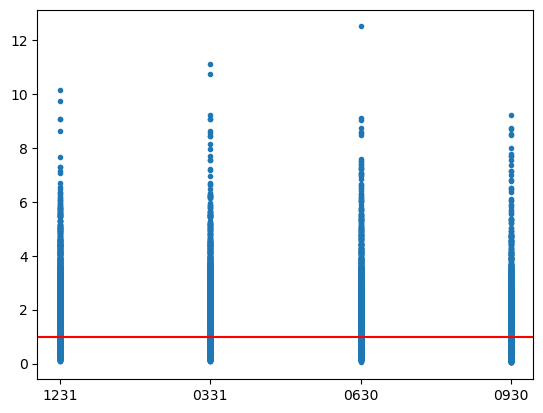

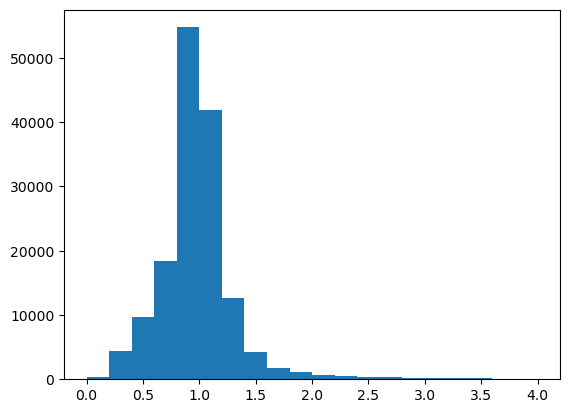

In [46]:
plt.axhline(1, color='red')
plt.scatter(reg_data4['report_type'].str[4:], reg_data4['DAVOL5'], marker='.')
plt.show()
plt.hist(reg_data4['DAVOL5'], bins=20, range=(0, 4))
plt.show()

In [26]:
x = ['book_time_rank_first', 'DAVOL5_rank', 'rets-10_-1_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['rets-10_-1_x']
reg(reg_data4, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rets-10_-1_x   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     5232.
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:17:14   Log-Likelihood:             1.6182e+05
No. Observations:              148977   AIC:                        -3.236e+05
Df Residuals:                  148966   BIC:                        -3.235e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0546      0.005     11.664      0.000       0.045       0.064
book_time_rank_first       -0.0305      0.001    -35.454      0.000      -0.032      -0.029
DAVOL5_rank                -0.0049      0.001     -6.306      0.000      -0.006      -0.003
rets-10_-1_y                1.0680      0.005    220.193      0.000       1.059       1.078
ln_assets                  -0.0018      0.000     -8.536      0.000      -0.002      -0.001
book_to_market_ratio_lf     0.0047      0.001      6.265      0.000       0.003       0.006
roe                         0.0001   8.25e-05      1.426      0.154   -4.41e-05       0.000
ia                          0.0002      0.000      1.189      0.234      -0.000       0.000
VOL5                    -5.409e-05   3.06e-05     -1.770      0.077      -0.000     5.8e-06
MTM                      2.028e-06   5.64e-05      0.036      0.971      -0.000       0.000
VOLT20                      0.0004      0.000      2.806      0.005       0.000       0.001
==============================================================================
Omnibus:                    70655.435   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1669026.106
Skew:                           1.761   Prob(JB):                         0.00
Kurtosis:                      19.015   Cond. No.                         530.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
x = ['book_time_rank_first', 'd_high', 'd_low', 'rets-10_-1_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['rets-10_-1_x']
reg(reg_data4, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rets-10_-1_x   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     4756.
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:17:14   Log-Likelihood:             1.6182e+05
No. Observations:              148977   AIC:                        -3.236e+05
Df Residuals:                  148965   BIC:                        -3.235e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0532      0.005     11.301      0.000       0.044       0.062
book_time_rank_first       -0.0305      0.001    -35.465      0.000      -0.032      -0.029
d_high                     -0.0032      0.001     -5.596      0.000      -0.004      -0.002
d_low                       0.0008      0.001      1.458      0.145      -0.000       0.002
rets-10_-1_y                1.0684      0.005    220.373      0.000       1.059       1.078
ln_assets                  -0.0018      0.000     -8.670      0.000      -0.002      -0.001
book_to_market_ratio_lf     0.0046      0.001      6.136      0.000       0.003       0.006
roe                         0.0001   8.25e-05      1.408      0.159   -4.55e-05       0.000
ia                          0.0002      0.000      1.193      0.233      -0.000       0.000
VOL5                    -5.479e-05   3.05e-05     -1.793      0.073      -0.000    5.09e-06
MTM                      1.383e-06   5.64e-05      0.025      0.980      -0.000       0.000
VOLT20                      0.0004      0.000      2.832      0.005       0.000       0.001
==============================================================================
Omnibus:                    70679.352   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1669854.979
Skew:                           1.761   Prob(JB):                         0.00
Kurtosis:                      19.019   Cond. No.                         530.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
reg_data4 = reg_data_before.loc[(reg_data_before['lag']==1) & 
    					 (reg_data_before['days_to_deadline']>0) & 
                         (reg_data_before['is_suspended'] == False) &
                         (reg_data_before['is_st'] == False) &
                         (reg_data_before['trade_date'] >= (reg_data_before['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_first', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'MTM', 'VOL5', 'VOLT20', 'total_a', 'net_profit', 'volume', 'circulation_a', 'DAVOL5']]

reg_data4['DAVOL5_rank'] = reg_data4.groupby('report_type')['DAVOL5'].rank(ascending=True, pct=True, method='min')
reg_data4.loc[reg_data4['DAVOL5_rank']>=0.8, 'd_high'] = 1
reg_data4.loc[reg_data4['DAVOL5_rank']<=0.2, 'd_low'] = 1
reg_data4['d_high'] = reg_data4['d_high'].fillna(0)
reg_data4['d_low'] = reg_data4['d_low'].fillna(0)

reg_data4 = pd.merge(left=reg_data4, right=get_interval_rets(1, 10, reg_data_before), on=['stock_symbol', 'report_type'], how='left')
reg_data4 = pd.merge(left=reg_data4, right=get_interval_rets(1, 10, index_data), on=['stock_symbol', 'report_type'], how='left')

reg_data4

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,market_cap_3,book_to_market_ratio_lf,roe,ia,MTM,...,net_profit,volume,circulation_a,DAVOL5,ln_assets,DAVOL5_rank,d_high,d_low,rets1_10_x,rets1_10_y
0,000001,20061231,2007-03-23,1,0.280156,3.771003e+10,0.171691,0.075299,0.103152,1.87,...,5.350840e+08,1.417865e+08,1.409362e+09,1.356491,24.353192,0.392675,0.0,0.0,0.029920,0.084225
1,000002,20061231,2007-03-21,1,0.248249,7.437568e+10,0.200097,0.034321,0.005183,3.01,...,6.161089e+08,1.864575e+08,3.254271e+09,1.223021,25.032395,0.109868,0.0,1.0,0.038797,0.068644
2,000006,20061231,2007-03-27,1,0.309728,3.687222e+09,0.345414,0.009664,0.122922,1.00,...,1.340063e+07,5.309325e+07,2.186029e+08,1.185449,22.028139,0.060020,0.0,1.0,0.024752,0.091288
3,000009,20061231,2007-04-19,1,0.684825,8.610114e+09,0.160723,0.038625,0.030145,1.48,...,8.246384e+07,9.363616e+07,5.797268e+08,1.587583,22.876203,0.858596,1.0,0.0,0.289528,0.174896
4,000012,20061231,2007-03-21,1,0.248249,1.484607e+10,0.177040,0.023285,0.009593,0.12,...,7.019879e+07,2.811287e+07,2.176773e+08,1.304594,23.421001,0.267548,0.0,0.0,0.036932,0.068644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152860,605003,20240630,2024-07-31,1,0.480769,1.793000e+09,0.780997,NaN,NaN,0.18,...,NaN,1.341375e+06,1.100000e+08,0.579962,21.307156,0.250000,0.0,0.0,NaN,NaN
152861,688018,20240630,2024-07-31,1,0.480769,1.222743e+10,0.158055,NaN,NaN,5.43,...,NaN,3.361250e+06,1.121885e+08,1.100126,23.226947,0.772727,0.0,0.0,NaN,NaN
152862,688100,20240630,2024-07-31,1,0.480769,1.976000e+10,0.152150,NaN,NaN,3.85,...,NaN,2.370254e+06,5.000000e+08,0.431809,23.706926,0.159091,0.0,1.0,NaN,NaN
152863,688510,20240630,2024-07-26,1,0.153846,4.529447e+09,0.235216,NaN,NaN,0.82,...,NaN,3.532993e+06,2.583826e+08,1.224694,22.233866,0.886364,1.0,0.0,NaN,NaN


In [29]:
x = ['book_time_rank_first', 'DAVOL5_rank', 'rets1_10_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['rets1_10_x']
reg(reg_data4, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rets1_10_x   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     4099.
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:17:32   Log-Likelihood:             1.6177e+05
No. Observations:              149264   AIC:                        -3.235e+05
Df Residuals:                  149253   BIC:                        -3.234e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.1362      0.005     29.281      0.000       0.127       0.145
book_time_rank_first        0.0075      0.001      8.687      0.000       0.006       0.009
DAVOL5_rank                -0.0092      0.001    -11.972      0.000      -0.011      -0.008
rets1_10_y                  1.0500      0.005    196.771      0.000       1.040       1.061
ln_assets                  -0.0058      0.000    -27.847      0.000      -0.006      -0.005
book_to_market_ratio_lf     0.0083      0.001     11.214      0.000       0.007       0.010
roe                     -1.162e-05   8.28e-05     -0.140      0.888      -0.000       0.000
ia                          0.0001      0.000      0.924      0.355      -0.000       0.000
VOL5                     5.297e-05   2.82e-05      1.877      0.060   -2.33e-06       0.000
MTM                        -0.0002   4.91e-05     -4.178      0.000      -0.000      -0.000
VOLT20                      0.0008      0.000      6.111      0.000       0.001       0.001
==============================================================================
Omnibus:                    71167.410   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1417388.046
Skew:                           1.827   Prob(JB):                         0.00
Kurtosis:                      17.647   Cond. No.                         583.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
x = ['book_time_rank_first', 'd_high', 'd_low', 'rets1_10_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['rets1_10_x']
reg(reg_data4, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rets1_10_x   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     3725.
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:17:32   Log-Likelihood:             1.6177e+05
No. Observations:              149264   AIC:                        -3.235e+05
Df Residuals:                  149252   BIC:                        -3.234e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.1326      0.005     28.317      0.000       0.123       0.142
book_time_rank_first        0.0076      0.001      8.846      0.000       0.006       0.009
d_high                     -0.0038      0.001     -6.699      0.000      -0.005      -0.003
d_low                       0.0042      0.001      7.602      0.000       0.003       0.005
rets1_10_y                  1.0507      0.005    196.945      0.000       1.040       1.061
ln_assets                  -0.0058      0.000    -28.130      0.000      -0.006      -0.005
book_to_market_ratio_lf     0.0084      0.001     11.330      0.000       0.007       0.010
roe                     -1.318e-05   8.28e-05     -0.159      0.874      -0.000       0.000
ia                          0.0001      0.000      0.935      0.350      -0.000       0.000
VOL5                     4.361e-05   2.82e-05      1.546      0.122   -1.17e-05    9.89e-05
MTM                        -0.0002   4.91e-05     -4.399      0.000      -0.000      -0.000
VOLT20                      0.0008      0.000      6.023      0.000       0.001       0.001
==============================================================================
Omnibus:                    71069.631   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1414712.856
Skew:                           1.824   Prob(JB):                         0.00
Kurtosis:                      17.634   Cond. No.                         583.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 分析师学习行为

In [31]:
reg_data5 = reg_data_before.loc[(reg_data_before['lag']==-10) & 
    					 (reg_data_before['days_to_deadline']>0) & 
                         (reg_data_before['is_suspended'] == False) &
                         (reg_data_before['is_st'] == False) &
                         (reg_data_before['trade_date'] >= (reg_data_before['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_first', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'MTM', 'VOL5', 'VOLT20', 'total_a', 'net_profit', 'volume', 'circulation_a', 'disp', 'bias']]

reg_data5 = pd.merge(left=reg_data5, right=get_interval_rets(-10, -1, reg_data_before), on=['stock_symbol', 'report_type'], how='left')
reg_data5 = pd.merge(left=reg_data5, right=get_interval_rets(-10, -1, index_data), on=['stock_symbol', 'report_type'], how='left')

reg_data5

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,ln_assets,book_to_market_ratio_lf,roe,ia,MTM,VOL5,VOLT20,total_a,net_profit,volume,circulation_a,disp,bias,rets-10_-1_x,rets-10_-1_y
0,000001,20061231,2007-03-08,-10,0.280156,24.328112,0.164617,0.075299,0.103152,0.51,8.068817,0.253528,1.945822e+09,5.350840e+08,7.334840e+07,1.409362e+09,0.486371,0.524020,0.052374,0.028530
1,000002,20061231,2007-03-06,-10,0.248249,24.925205,0.148887,0.034321,0.005183,-0.07,6.122321,0.268112,3.822001e+09,6.161089e+08,1.296845e+08,3.254271e+09,0.235743,0.339316,0.083074,0.055200
2,000006,20061231,2007-03-12,-10,0.309728,21.967901,0.356286,0.009664,0.122922,1.26,27.405958,0.115292,2.535916e+08,1.340063e+07,3.925960e+07,2.186029e+08,0.092256,0.064259,0.088411,0.038260
3,000007,20061231,2007-04-06,-10,0.734630,20.695810,0.065745,0.681624,-0.039944,0.79,8.716581,0.233468,1.849654e+08,-1.144691e+07,1.343641e+07,1.209327e+08,NaN,NaN,0.142584,0.059991
4,000008,20061231,2007-03-15,-10,0.396109,20.112296,0.133207,0.013152,0.068287,0.82,59.018713,0.052673,7.365321e+07,1.003699e+06,1.903524e+07,4.234860e+07,NaN,NaN,0.024381,0.057494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152598,605003,20240630,2024-07-16,-10,0.480769,21.301619,0.797826,NaN,NaN,-0.05,0.615468,0.321028,1.100000e+08,NaN,3.393000e+05,1.100000e+08,NaN,NaN,-0.004318,-0.030741
152599,688018,20240630,2024-07-16,-10,0.480769,23.245762,0.151087,NaN,NaN,28.53,2.499410,9.454977,1.121885e+08,NaN,3.117270e+06,1.121885e+08,NaN,NaN,-0.075815,-0.030741
152600,688100,20240630,2024-07-16,-10,0.480769,23.606669,0.158779,NaN,NaN,-1.71,0.204979,1.156185,5.000000e+08,NaN,8.351080e+05,5.000000e+08,NaN,NaN,-0.009231,-0.030741
152601,688510,20240630,2024-07-11,-10,0.153846,22.268623,0.230419,NaN,NaN,-0.29,0.855331,0.643697,2.583826e+08,NaN,2.350849e+06,2.583826e+08,NaN,NaN,0.006612,-0.014418


In [32]:
x = ['book_time_rank_first', 'rets-10_-1_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['disp']
reg(reg_data5, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   disp   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.932
Date:                Thu, 08 Aug 2024   Prob (F-statistic):             0.0430
Time:                        15:17:49   Log-Likelihood:                -62381.
No. Observations:               33070   AIC:                         1.248e+05
Df Residuals:                   33060   BIC:                         1.249e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.1606      0.195      0.825      0.410      -0.221       0.542
book_time_rank_first        0.0434      0.033      1.336      0.182      -0.020       0.107
rets-10_-1_y                0.1303      0.219      0.595      0.552      -0.299       0.559
ln_assets                   0.0086      0.008      1.021      0.307      -0.008       0.025
book_to_market_ratio_lf    -0.0082      0.030     -0.275      0.784      -0.067       0.050
roe                        -0.2231      0.083     -2.690      0.007      -0.386      -0.061
ia                          0.0312      0.031      1.004      0.315      -0.030       0.092
VOL5                       -0.0016      0.001     -1.207      0.227      -0.004       0.001
MTM                        -0.0002      0.002     -0.067      0.947      -0.005       0.004
VOLT20                     -0.0108      0.005     -2.107      0.035      -0.021      -0.001
==============================================================================
Omnibus:                    83827.642   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      25577341794.842
Skew:                          26.987   Prob(JB):                         0.00
Kurtosis:                    4311.064   Cond. No.                         582.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
x = ['book_time_rank_first', 'rets-10_-1_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['bias']
reg(reg_data5, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   bias   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     17.78
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           8.59e-30
Time:                        15:17:49   Log-Likelihood:            -1.4153e+05
No. Observations:               33070   AIC:                         2.831e+05
Df Residuals:                   33060   BIC:                         2.832e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      14.5727      2.133      6.832      0.000      10.392      18.753
book_time_rank_first        2.3414      0.356      6.573      0.000       1.643       3.040
rets-10_-1_y                6.4481      2.397      2.690      0.007       1.750      11.146
ln_assets                  -0.5787      0.092     -6.258      0.000      -0.760      -0.397
book_to_market_ratio_lf     1.6260      0.326      4.983      0.000       0.986       2.266
roe                        -4.0386      0.908     -4.447      0.000      -5.819      -2.259
ia                          0.7482      0.340      2.198      0.028       0.081       1.415
VOL5                        0.0139      0.015      0.941      0.346      -0.015       0.043
MTM                         0.0049      0.025      0.195      0.846      -0.045       0.054
VOLT20                     -0.0225      0.056     -0.400      0.689      -0.133       0.088
==============================================================================
Omnibus:                   110094.835   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      35266121584.909
Skew:                          58.612   Prob(JB):                         0.00
Kurtosis:                    5060.673   Cond. No.                         582.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
reg_data_before.columns

Index(['stock_symbol', 'report_type', 'trade_date', 'lag',
       'book_time_rank_first', 'book_time_rank_last', 'report_time_rank_last',
       'days_to_deadline', 'market_cap_3', 'book_to_market_ratio_lf',
       'du_return_on_equity_ttm', 'VOL5', 'MTM', 'VOLT20', 'VOLT10',
       'total_assets_mrq_0', 'return_on_asset_ttm', 'DAVOL5', 'prev_close',
       'total_turnover', 'num_trades', 'high', 'close', 'limit_up', 'low',
       'volume', 'limit_down', 'open', 'is_suspended', 'is_st',
       'circulation_a', 'non_circulation_a', 'total_a', 'free_circulation',
       'preferred_shares', 'total', 'listed_date', 'ln_assets',
       'total_liabilities', 'net_profit', 'total_assets', 'total_equity',
       'basic_earnings_per_share', 'roa', 'roe', 'ia', 'eps_lag1', 'ue',
       'report_type_lag1', 'bias', 'count', 'fprofit', 'eps', 'feps_std',
       'feps_mean', 'disp'],
      dtype='object')

In [50]:
reg_data5 = reg_data_before.loc[(reg_data_before['lag']==-10) & 
    					 (reg_data_before['days_to_deadline']>0) & 
                         (reg_data_before['is_suspended'] == False) &
                         (reg_data_before['is_st'] == False) &
                         (reg_data_before['trade_date'] >= (reg_data_before['listed_date'] + datetime.timedelta(days=365))) &
						 (reg_data_before['count'] > 1),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_first', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'MTM', 'VOL5', 'VOLT20', 'total_a', 'net_profit', 'volume', 'circulation_a', 'disp', 'bias']]

reg_data5 = pd.merge(left=reg_data5, right=get_interval_rets(-10, -1, reg_data_before), on=['stock_symbol', 'report_type'], how='left')
reg_data5 = pd.merge(left=reg_data5, right=get_interval_rets(-10, -1, index_data), on=['stock_symbol', 'report_type'], how='left')

reg_data5

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,ln_assets,book_to_market_ratio_lf,roe,ia,MTM,VOL5,VOLT20,total_a,net_profit,volume,circulation_a,disp,bias,rets-10_-1_x,rets-10_-1_y
0,000001,20061231,2007-03-08,-10,0.280156,24.328112,0.164617,0.075299,0.103152,0.51,8.068817,0.253528,1.945822e+09,5.350840e+08,7.334840e+07,1.409362e+09,0.486371,0.524020,0.052374,0.028530
1,000002,20061231,2007-03-06,-10,0.248249,24.925205,0.148887,0.034321,0.005183,-0.07,6.122321,0.268112,3.822001e+09,6.161089e+08,1.296845e+08,3.254271e+09,0.235743,0.339316,0.083074,0.055200
2,000006,20061231,2007-03-12,-10,0.309728,21.967901,0.356286,0.009664,0.122922,1.26,27.405958,0.115292,2.535916e+08,1.340063e+07,3.925960e+07,2.186029e+08,0.092256,0.064259,0.088411,0.038260
3,000012,20061231,2007-03-06,-10,0.248249,23.347945,0.185438,0.023285,0.009593,0.65,11.867980,0.301939,5.668843e+08,7.019879e+07,9.185527e+06,2.176773e+08,0.325498,0.671542,0.000000,0.055200
4,000021,20061231,2007-04-09,-10,0.803113,23.308255,0.227114,0.105540,0.020523,2.05,10.244785,0.356040,8.795185e+08,3.780935e+08,2.697825e+07,3.116781e+08,0.061868,0.080891,0.060346,0.082652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33087,688798,20231231,2024-03-25,-10,0.253734,23.282985,0.272713,0.009747,-0.003293,-5.88,1.350332,2.263231,2.320089e+08,3.582307e+07,2.237597e+06,1.346235e+08,0.780173,10.123593,-0.048440,0.002191
33088,688800,20231231,2024-04-02,-10,0.348270,22.295860,0.403550,0.021566,0.091097,-0.16,3.204040,1.601444,1.584199e+08,4.362625e+07,2.330613e+06,1.065891e+08,0.297031,2.446536,-0.151546,-0.004265
33089,688819,20231231,2024-03-18,-10,0.159395,24.095500,0.508207,0.031438,0.205929,1.23,0.228896,0.685687,9.721000e+08,5.076359e+08,2.297761e+06,9.721000e+08,0.240178,0.205907,-0.049366,-0.018328
33090,688981,20231231,2024-03-15,-10,0.114976,26.639143,0.385601,0.002058,0.009734,1.75,1.101263,1.394649,1.973609e+09,4.501600e+08,1.619596e+07,1.973609e+09,0.532905,0.612890,-0.057210,-0.013733


In [51]:
x = ['book_time_rank_first', 'rets-10_-1_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['bias']
reg(reg_data5, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   bias   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     17.78
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           8.59e-30
Time:                        15:29:44   Log-Likelihood:            -1.4153e+05
No. Observations:               33070   AIC:                         2.831e+05
Df Residuals:                   33060   BIC:                         2.832e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      14.5727      2.133      6.832      0.000      10.392      18.753
book_time_rank_first        2.3414      0.356      6.573      0.000       1.643       3.040
rets-10_-1_y                6.4481      2.397      2.690      0.007       1.750      11.146
ln_assets                  -0.5787      0.092     -6.258      0.000      -0.760      -0.397
book_to_market_ratio_lf     1.6260      0.326      4.983      0.000       0.986       2.266
roe                        -4.0386      0.908     -4.447      0.000      -5.819      -2.259
ia                          0.7482      0.340      2.198      0.028       0.081       1.415
VOL5                        0.0139      0.015      0.941      0.346      -0.015       0.043
MTM                         0.0049      0.025      0.195      0.846      -0.045       0.054
VOLT20                     -0.0225      0.056     -0.400      0.689      -0.133       0.088
==============================================================================
Omnibus:                   110094.835   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      35266121584.909
Skew:                          58.612   Prob(JB):                         0.00
Kurtosis:                    5060.673   Cond. No.                         582.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
x = ['book_time_rank_first', 'rets-10_-1_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['disp']
reg(reg_data5, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   disp   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.932
Date:                Thu, 08 Aug 2024   Prob (F-statistic):             0.0430
Time:                        15:29:44   Log-Likelihood:                -62381.
No. Observations:               33070   AIC:                         1.248e+05
Df Residuals:                   33060   BIC:                         1.249e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.1606      0.195      0.825      0.410      -0.221       0.542
book_time_rank_first        0.0434      0.033      1.336      0.182      -0.020       0.107
rets-10_-1_y                0.1303      0.219      0.595      0.552      -0.299       0.559
ln_assets                   0.0086      0.008      1.021      0.307      -0.008       0.025
book_to_market_ratio_lf    -0.0082      0.030     -0.275      0.784      -0.067       0.050
roe                        -0.2231      0.083     -2.690      0.007      -0.386      -0.061
ia                          0.0312      0.031      1.004      0.315      -0.030       0.092
VOL5                       -0.0016      0.001     -1.207      0.227      -0.004       0.001
MTM                        -0.0002      0.002     -0.067      0.947      -0.005       0.004
VOLT20                     -0.0108      0.005     -2.107      0.035      -0.021      -0.001
==============================================================================
Omnibus:                    83827.642   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      25577341794.842
Skew:                          26.987   Prob(JB):                         0.00
Kurtosis:                    4311.064   Cond. No.                         582.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""